In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G, discount_ts, strip_bm_path
from signature.signature.expected_signature import expected_signature, expected_stationary_signature
from signature.signature.learning.sig_moment_matching import StatSigSignal

from simulation.diffusion import Diffusion


my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

In [2]:
N = 6

In [3]:
%%time
ta = TensorAlgebra(dim=2, trunc=N)

Compiling...
Compilation finished.
CPU times: total: 4min 57s
Wall time: 7min 31s


In [4]:
e0 = ta.from_dict({"": 1}, trunc=N)

e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)

e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)

e212 = ta.from_dict({"212": 1}, trunc=N)
e222 = ta.from_dict({"222": 1}, trunc=N)

# Standard signatures of the stationary signal

In [5]:
trunc_model = 3
trunc_moments = 5

In [6]:
%%time

T = 100
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 15
size = 2

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=trunc_model, t_grid=t_grid, lam=lam)

CPU times: total: 10.3 s
Wall time: 12.4 s


In [7]:
%%time
rng_ = np.random.default_rng(seed=42)
model = StatSigSignal(trunc=3, lam=lam, t_grid=t_grid_pos, rng=rng_)

Compiling...
Compilation finished.
CPU times: total: 3.38 s
Wall time: 5.15 s


In [8]:
ell = e22 * 5 + e2 + e12 * 5
signal = (ell @ SigS).squeeze().real

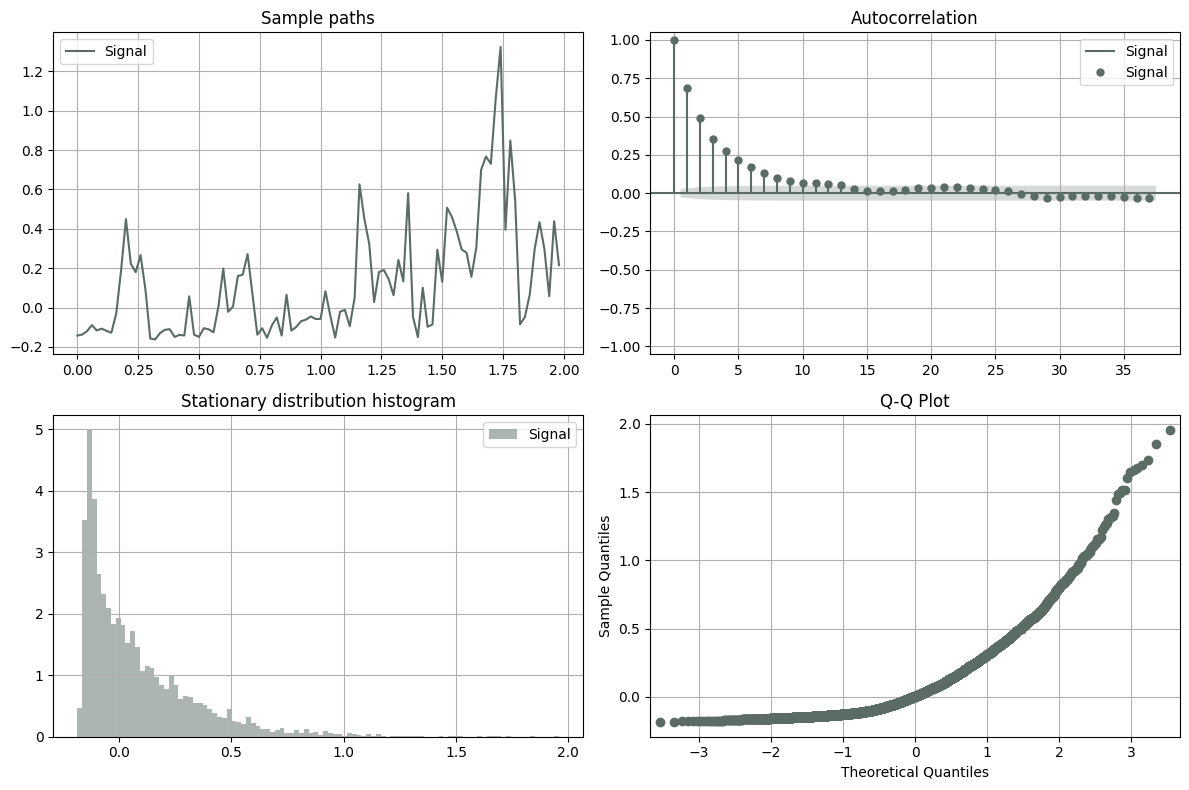

In [9]:
model.analysis(signal, window_size=100)

In [10]:
def run_calib(weights, optimizer):
    model.loss_weights = weights
    model.optimizer = optimizer
    print(f"Calibrating with weights {model.loss_weights} using the solver {model.optimizer}")
    model.fit(signal)
    print("Calibrated coefficients:")
    ta.print(model.l)
    model.analysis(signal)

Calibrating with weights (1, 0.01) using the solver Powell
Esig: 0.012974547994681486, Stationary moments: 0.0013885800686475214
New iteration: 
 x = [ 0.00783313  0.00128956  0.00696941  0.009405   -0.01957965 -0.01304048
  0.00128434 -0.00316414], 
 val=0.014363128063329008. 

Esig: 0.012971777208069407, Stationary moments: 0.0013875384306713651
New iteration: 
 x = [-3.75045666e+00  1.28943940e-03  6.96875733e-03  9.40479970e-03
 -1.96504416e-02 -1.30601066e-02  1.29149972e-03 -3.16585151e-03], 
 val=0.014359315638740773. 

Esig: 0.011839121348346509, Stationary moments: 0.0009972113421744303
New iteration: 
 x = [-1.27863785e+03  1.24787315e-03  6.74751578e-03  9.33533367e-03
 -4.36959327e-02 -1.97276066e-02  3.73054578e-03 -3.78655247e-03], 
 val=0.01283633269052094. 

Esig: 0.011584077982817834, Stationary moments: 0.0009698595072238582
New iteration: 
 x = [-1.27865936e+03  1.24840293e-03  6.74746240e-03  9.33532714e-03
 -4.05367632e-02 -1.97275285e-02  3.73891790e-03 -3.7903883

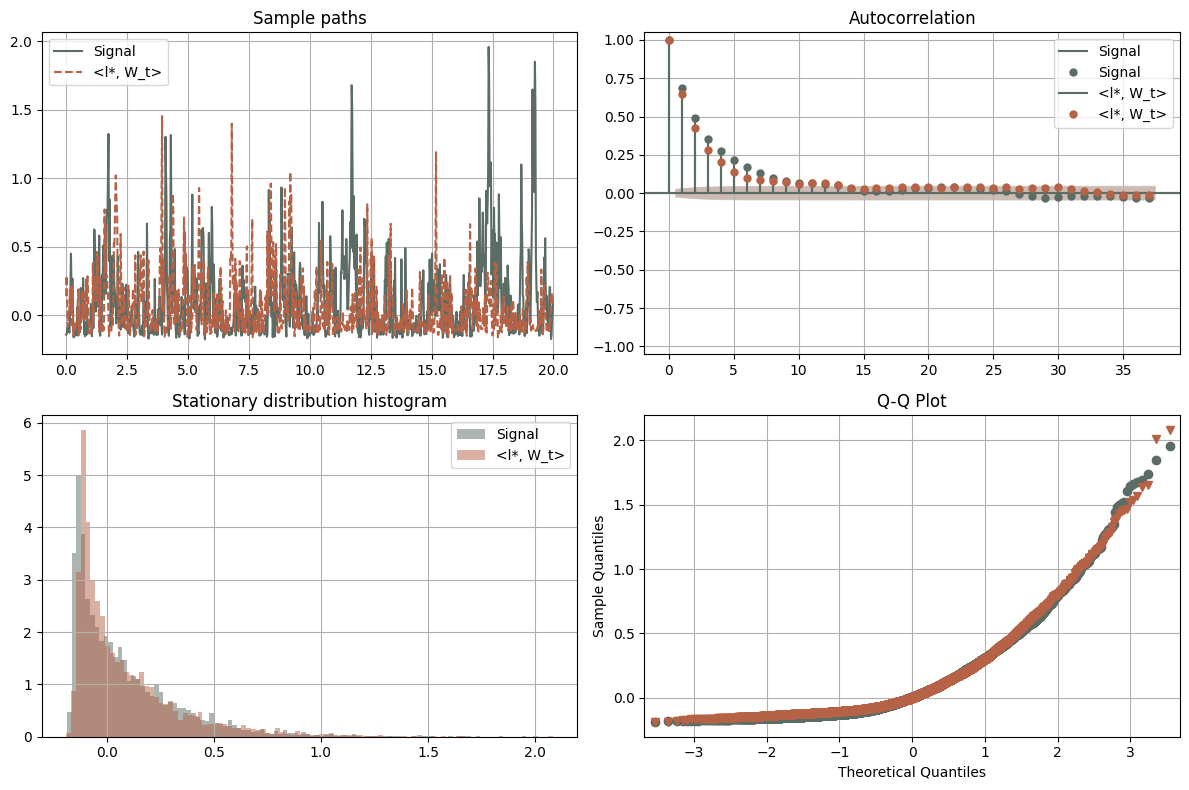

In [11]:
run_calib(weights=(1, 0.01), optimizer="Powell")

Calibrating with weights (1, 0.01) using the solver BFGS
Esig: 0.23765214456900424, Stationary moments: 83.10415998417977
New iteration: 
 x = [ 0.00304717  0.06561627  0.01167491  0.08952133 -0.0193947  -0.01048513
  0.00284325 -0.01549647], 
 val=83.34181212874877. 

Esig: 0.016421446851496834, Stationary moments: 0.22788721744429544
New iteration: 
 x = [ 0.00304717  0.02722013  0.01009228  0.14129501 -0.01943074 -0.00872207
  0.00386827 -0.01212328], 
 val=0.24430866429579226. 

Esig: 0.014589214781761334, Stationary moments: 0.020955452314493122
New iteration: 
 x = [ 0.00304717  0.02662893  0.01013511  0.14178982 -0.01942868 -0.00872709
  0.00388411 -0.01353743], 
 val=0.03554466709625446. 

Esig: 0.013799664928454516, Stationary moments: 0.002314685967000742
New iteration: 
 x = [ 0.00304717  0.02653051  0.00653632  0.14213604 -0.01976034 -0.01481798
  0.00643061 -0.0141232 ], 
 val=0.016114350895455258. 

Esig: 0.013705290602967463, Stationary moments: 0.0021075803265125552
New

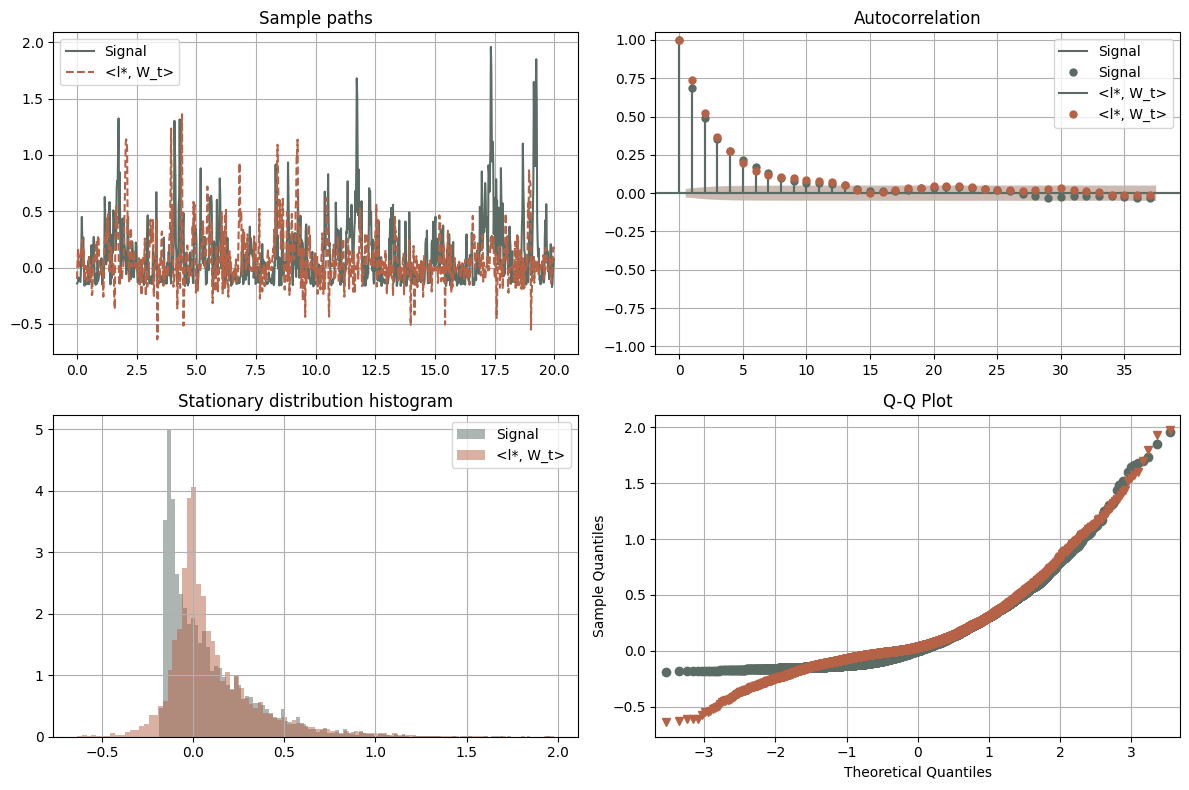

In [12]:
run_calib(weights=(1, 0.01), optimizer="BFGS")

Calibrating with weights (1, 0.0) using the solver Powell
Esig: 0.004357761708313836, Stationary moments: 0.0
New iteration: 
 x = [ 0.08751993 -0.00284287  0.00750558  0.0094027  -0.02038473 -0.01329906
  0.00272377 -0.00361661], 
 val=0.004357761708313836. 

Esig: 0.004296740836658486, Stationary moments: 0.0
New iteration: 
 x = [ 1.60840704 -0.00286279  0.00714829  0.00939917 -0.02120667 -0.01357923
  0.00414539 -0.00417676], 
 val=0.004296740836658486. 

Esig: 0.00414714425593774, Stationary moments: 0.0
New iteration: 
 x = [ 5.64718388e+00 -2.92303671e-03  6.36675330e-03  9.38615407e-03
 -2.36684740e-02 -1.44697164e-02  8.60901693e-03 -6.61245108e-03], 
 val=0.00414714425593774. 

Esig: 0.003847278364339302, Stationary moments: 0.0
New iteration: 
 x = [ 1.57490812e+01 -3.05925893e-03  4.58819832e-03  9.34471148e-03
 -3.04348025e-02 -1.69897507e-02  2.11832792e-02 -1.31790248e-02], 
 val=0.003847278364339302. 

Esig: 0.0036127857123528723, Stationary moments: 0.0
New iteration: 

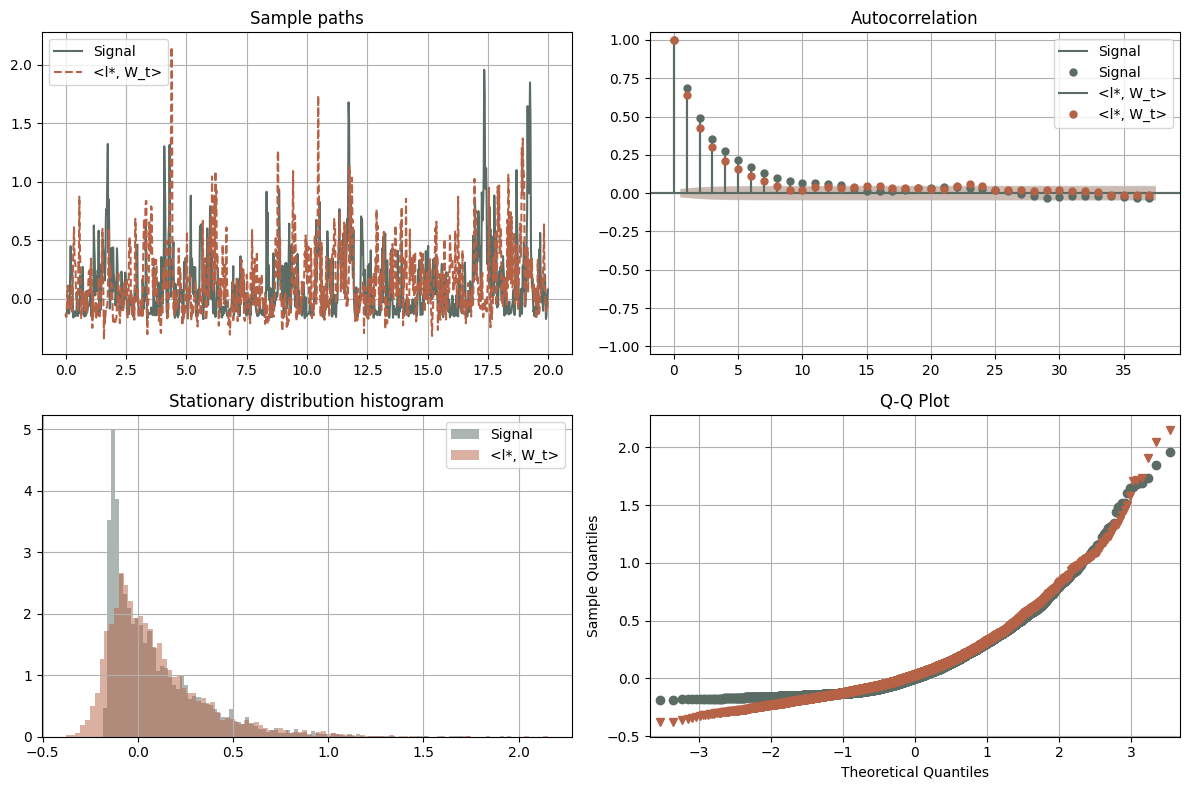

In [13]:
run_calib(weights=(1, 0.0), optimizer="Powell")

Calibrating with weights (1, 0.0) using the solver BFGS
Esig: 0.1378894835477179, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304717  0.01414671  0.00887948  0.0360037  -0.01946863 -0.01216188
  0.00176127 -0.0051178 ], 
 val=0.1378894835477179. 

Esig: 0.014281882418372095, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304717  0.00951616  0.00872392  0.05238334 -0.01947147 -0.01162667
  0.00206259 -0.0053676 ], 
 val=0.014281882418372095. 

Esig: 0.006770625429857527, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.00750835  0.01290432  0.05308163 -0.01927263 -0.0135249
  0.00264293 -0.01798062], 
 val=0.006770625429857527. 

Esig: 0.00563770172213737, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304718  0.00626275  0.01610373  0.0531761  -0.01932309 -0.01850177
  0.00429104 -0.02379692], 
 val=0.00563770172213737. 

Esig: 0.005199113015882193, Stationary moments: 0.0
New iteration: 
 x = [ 0.00304717  0.00514185  0.01952026  0.0526659  -0.01940155 -0.02

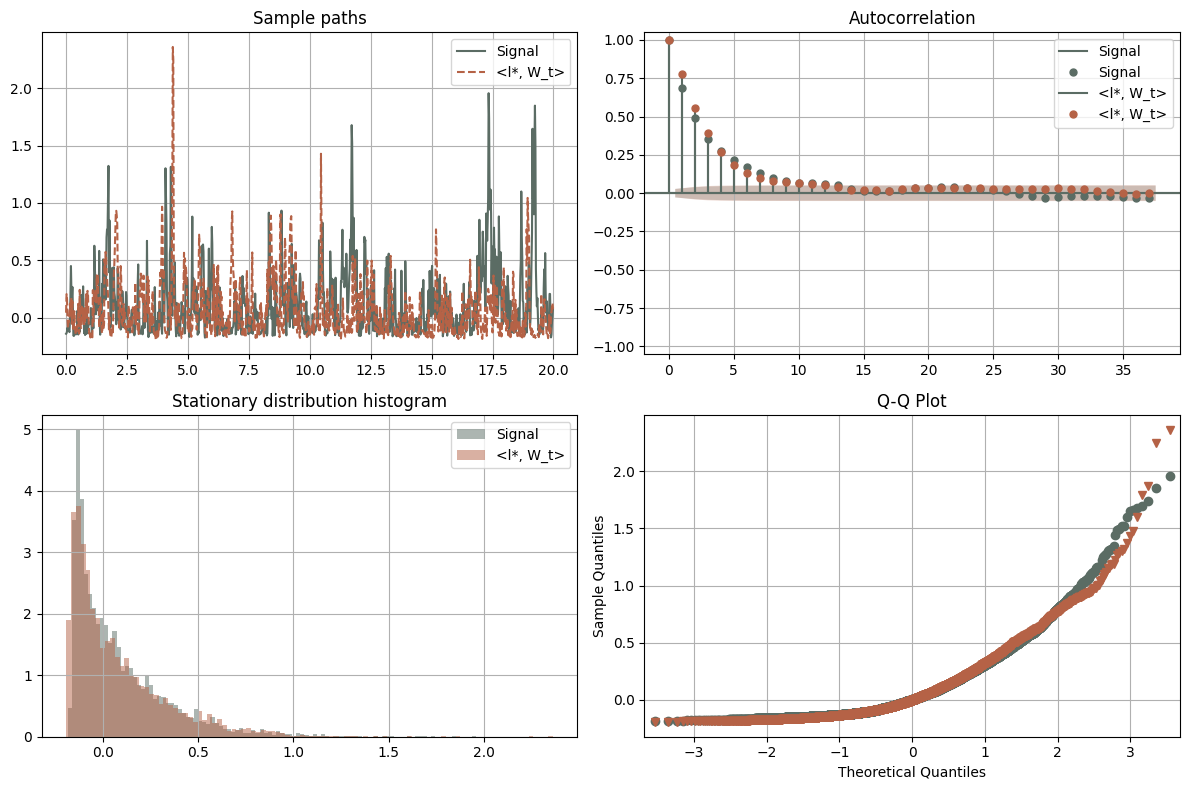

In [14]:
run_calib(weights=(1, 0.0), optimizer="BFGS")

Calibrating with weights (0, 0.01) using the solver Powell
Esig: 0.0, Stationary moments: 0.0014302366708508244
New iteration: 
 x = [ 0.0045666   0.00125059  0.00780917  0.00940572 -0.01952538 -0.01302505
  0.001279   -0.00316322], 
 val=0.0014302366708508244. 

Esig: 0.0, Stationary moments: 0.0014298424318052588
New iteration: 
 x = [-2.53865076e+00  1.25053643e-03  7.80902201e-03  9.40566482e-03
 -1.95397662e-02 -1.30284261e-02  1.27974632e-03 -3.16401701e-03], 
 val=0.0014298424318052588. 

Esig: 0.0, Stationary moments: 0.0012782177977030422
New iteration: 
 x = [-9.51366232e+02  1.23199094e-03  7.75249741e-03  9.38634186e-03
 -2.49184390e-02 -1.42889234e-02  1.55703267e-03 -3.46693801e-03], 
 val=0.0012782177977030422. 

Esig: 0.0, Stationary moments: 0.0012705578879004748
New iteration: 
 x = [-9.79878111e+02  1.23145344e-03  7.75178176e-03  9.38577954e-03
 -2.50753179e-02 -1.43284226e-02  1.56482705e-03 -3.47795101e-03], 
 val=0.0012705578879004748. 

Esig: 0.0, Stationary mom

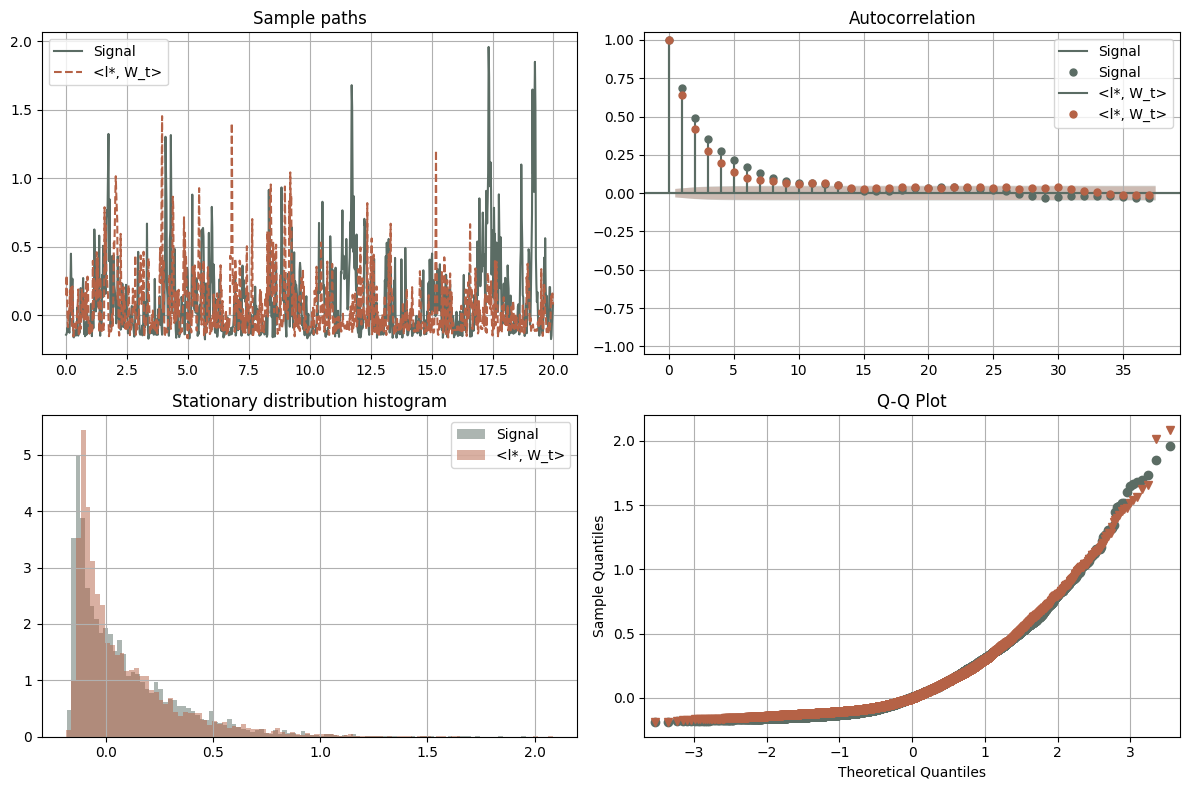

CPU times: total: 1h 15min 30s
Wall time: 1h 17min 57s


In [17]:
%%time
run_calib(weights=(0, 0.01), optimizer="Powell")

Calibrating with weights (0, 0.01) using the solver BFGS
Esig: 0.0, Stationary moments: 83.11034464941015
New iteration: 
 x = [ 0.00304717  0.06562455  0.01167485  0.08951667 -0.01939476 -0.01048561
  0.00284383 -0.01553512], 
 val=83.11034464941015. 

Esig: 0.0, Stationary moments: 0.002226453170071855
New iteration: 
 x = [ 0.00304717  0.02654067  0.01006546  0.14223768 -0.01943136 -0.00869015
  0.00388801 -0.01209207], 
 val=0.002226453170071855. 

Esig: 0.0, Stationary moments: 0.002224710795320274
New iteration: 
 x = [ 0.00304717  0.02654488  0.01006327  0.14223862 -0.01943146 -0.00868967
  0.00388785 -0.0120608 ], 
 val=0.002224710795320274. 

Esig: 0.0, Stationary moments: 0.002085792218858516
New iteration: 
 x = [ 0.00304715  0.02728247 -0.01164788  0.14211011 -0.02052145 -0.00948556
  0.00291779 -0.01597905], 
 val=0.002085792218858516. 

Esig: 0.0, Stationary moments: 0.0020363608428755247
New iteration: 
 x = [ 0.00304714  0.02767027 -0.02345975  0.14203147 -0.02112515 -0

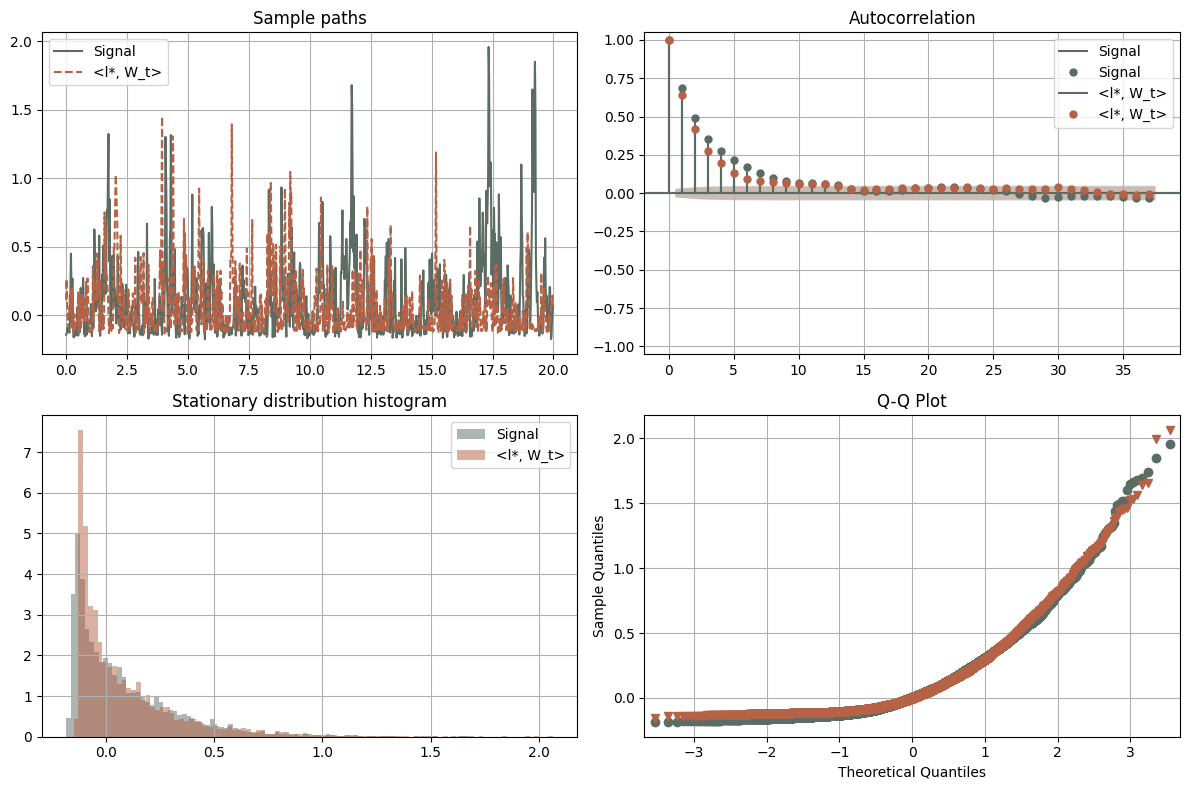

CPU times: total: 11min 51s
Wall time: 12min 13s


In [18]:
%%time
run_calib(weights=(0, 0.01), optimizer="BFGS")

Calibrating with weights (1, 0.001) using the solver Powell
Esig: 0.012869263476730812, Stationary moments: 0.00016472777547655947
New iteration: 
 x = [ 0.00902638  0.00129215  0.00685744  0.00940366 -0.02005983 -0.0131775
  0.00133137 -0.00317231], 
 val=0.013033991252207371. 

Esig: 0.012849867756910001, Stationary moments: 0.0001641104583723875
New iteration: 
 x = [ 1.64497745e+00  1.29135062e-03  6.85248229e-03  9.40214228e-03
 -2.06095812e-02 -1.33316085e-02  1.38182386e-03 -3.18210148e-03], 
 val=0.013013978215282388. 

Esig: 0.008400077285442004, Stationary moments: 0.00017862404555055582
New iteration: 
 x = [ 3.35957605e+02  1.12226481e-03  5.84166347e-03  9.09153204e-03
 -1.33087115e-01 -4.48616633e-02  1.17285149e-02 -5.18459588e-03], 
 val=0.008578701330992559. 

Esig: 0.007315567233379279, Stationary moments: 4.752762937180302e-05
New iteration: 
 x = [ 3.91024710e+02  1.08827913e-03  5.67336745e-03  9.04067240e-03
 -1.50138734e-01 -5.00490447e-02  1.38213777e-02 -5.5564

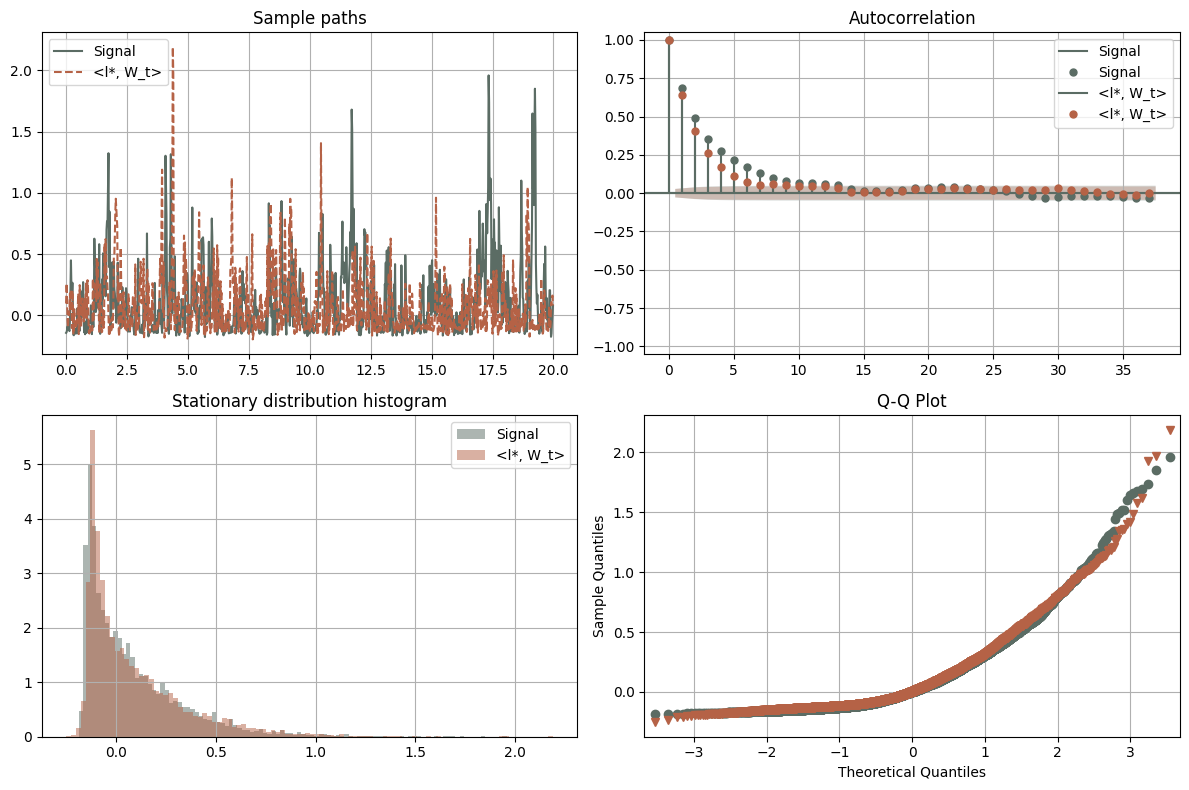

CPU times: total: 32min 14s
Wall time: 33min 2s


In [19]:
%%time
run_calib(weights=(1, 0.001), optimizer="Powell")

Calibrating with weights (1, 0.001) using the solver BFGS
Esig: 0.2374154861324929, Stationary moments: 8.305152705927174
New iteration: 
 x = [ 0.00304717  0.06554553  0.01167545  0.08956043 -0.01939412 -0.01048112
  0.00283829 -0.01516837], 
 val=8.542568192059667. 

Esig: 0.013025993481093888, Stationary moments: 0.00447891360659484
New iteration: 
 x = [ 0.00304717  0.02622797  0.01004118  0.14240052 -0.01943182 -0.00868291
  0.00388098 -0.01179497], 
 val=0.017504907087688728. 

Esig: 0.01395416478202102, Stationary moments: 0.00033513468273452246
New iteration: 
 x = [ 0.00304717  0.02679561  0.00979506  0.14257888 -0.01944294 -0.00861237
  0.00385989 -0.00725198], 
 val=0.014289299464755543. 

Esig: 0.012918574866021593, Stationary moments: 0.00024119078278046562
New iteration: 
 x = [ 0.0030472   0.02735591 -0.04168079  0.14087728 -0.02260707 -0.01955049
 -0.00037231 -0.03507861], 
 val=0.01315976564880206. 

Esig: 0.012515521822490454, Stationary moments: 0.0004113769072902964

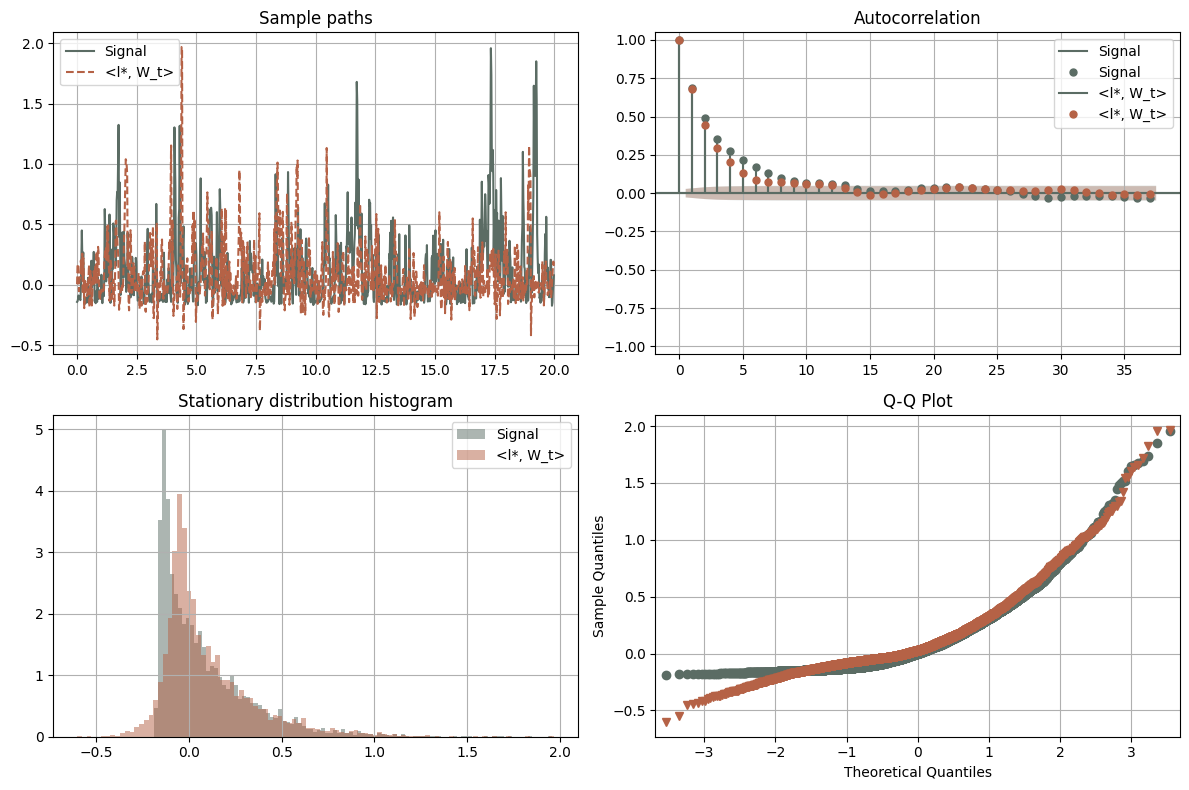

CPU times: total: 23min 34s
Wall time: 24min 3s


In [20]:
%%time
run_calib(weights=(1, 0.001), optimizer="BFGS")

In [458]:
model.loss_weights = (1, 0.0002)
model.optimizer = "BFGS"

In [459]:
model.loss_weights

(1, 0.0002)

In [460]:
%%time
model.fit(signal)

Esig: 0.14797395520253523, Stationary moments: 1.1882399392867076
New iteration: 
 x = [ 0.00304717  0.01502505  0.00890595  0.03637089 -0.01947065 -0.01216388
  0.00179657 -0.0068164 ], 
 val=1.3362138944892428. 

Esig: 0.03771124641119577, Stationary moments: 0.1852696133866863
New iteration: 
 x = [ 0.00304717  0.01328459  0.00897172  0.05852295 -0.01946632 -0.01143953
  0.00222787 -0.00792794], 
 val=0.22298085979788207. 

Esig: 0.011047557800332362, Stationary moments: 4.504988271823748e-05
New iteration: 
 x = [ 0.00304717  0.00963852  0.01123676  0.06420423 -0.01936278 -0.01191676
  0.00257317 -0.04226435], 
 val=0.0110926076830506. 

Esig: 0.009847927922987255, Stationary moments: 0.00024140666383931606
New iteration: 
 x = [ 0.00304717  0.01005526 -0.00395174  0.06461455 -0.02037634 -0.01974073
  0.00320206 -0.04456298], 
 val=0.010089334586826572. 

Esig: 0.008244862064577516, Stationary moments: 5.460142299582441e-06
New iteration: 
 x = [ 0.00304717  0.01101588 -0.04131037 

In [461]:
ta.print(model.l)

-0.009615303805915215*∅ + 2.485744656985014*2 + -32.055412998487114*12 + 16.245399610922238*22 + -54.99303031019193*112 + -240.1389973880164*122 + -8.629016345380816*212 + -18.852420331595503*222


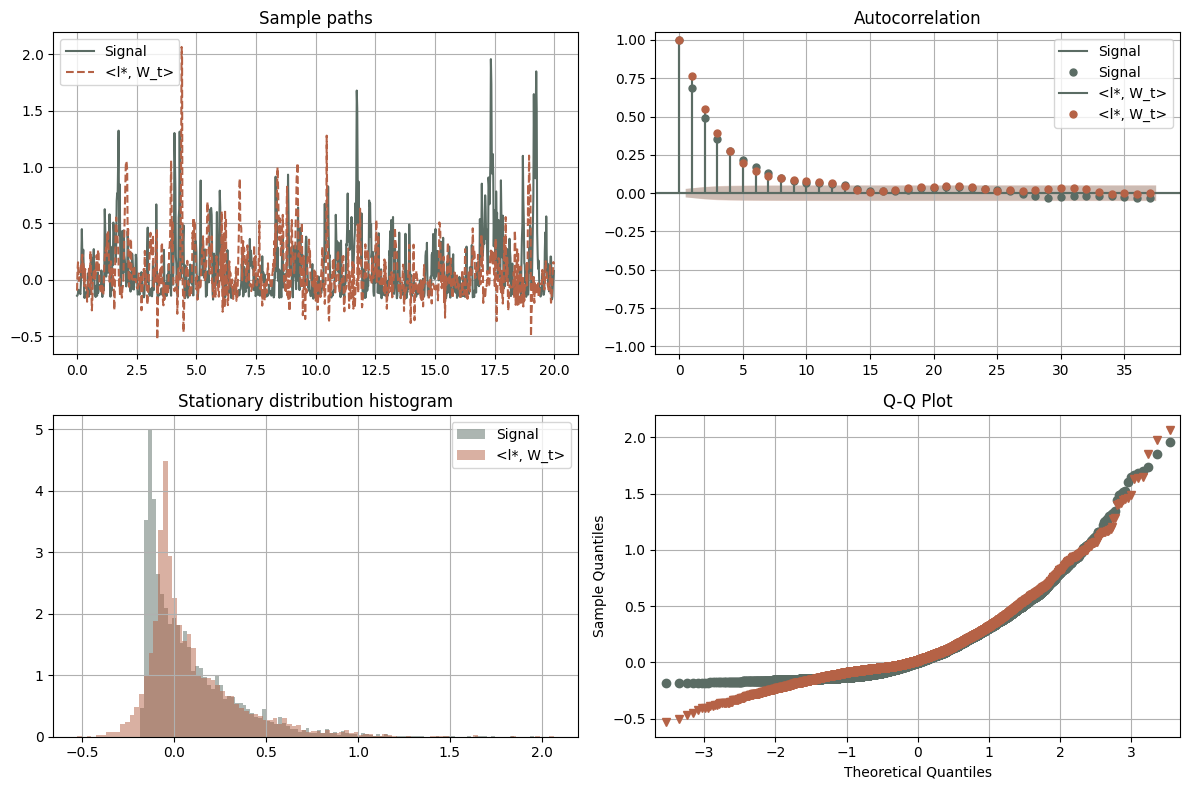

In [462]:
model.analysis(signal)

In [463]:
model.loss_weights = (1, 0.001)
model.optimizer = "Powell"

In [464]:
model.loss_weights

(1, 0.001)

In [465]:
%%time
model.fit(signal)

Esig: 0.012869263476730812, Stationary moments: 0.00016472777547655947
New iteration: 
 x = [ 0.00902638  0.00129215  0.00685744  0.00940366 -0.02005983 -0.0131775
  0.00133137 -0.00317231], 
 val=0.013033991252207371. 

Esig: 0.012849867756910001, Stationary moments: 0.0001641104583723875
New iteration: 
 x = [ 1.64497745e+00  1.29135062e-03  6.85248229e-03  9.40214228e-03
 -2.06095812e-02 -1.33316085e-02  1.38182386e-03 -3.18210148e-03], 
 val=0.013013978215282388. 

Esig: 0.008400077285442004, Stationary moments: 0.00017862404555055582
New iteration: 
 x = [ 3.35957605e+02  1.12226481e-03  5.84166347e-03  9.09153204e-03
 -1.33087115e-01 -4.48616633e-02  1.17285149e-02 -5.18459588e-03], 
 val=0.008578701330992559. 

Esig: 0.007315567233379279, Stationary moments: 4.752762937180302e-05
New iteration: 
 x = [ 3.91024710e+02  1.08827913e-03  5.67336745e-03  9.04067240e-03
 -1.50138734e-01 -5.00490447e-02  1.38213777e-02 -5.55642974e-03], 
 val=0.007363094862751082. 

Esig: 0.00523193218

-0.03895680447516767*∅ + 1.171704809227522*2 + 6.041166255515086*12 + 9.7259240634249*22 + -161.72571705311196*112 + -53.839771727546925*122 + 16.394234873563217*212 + -22.7916113782825*222


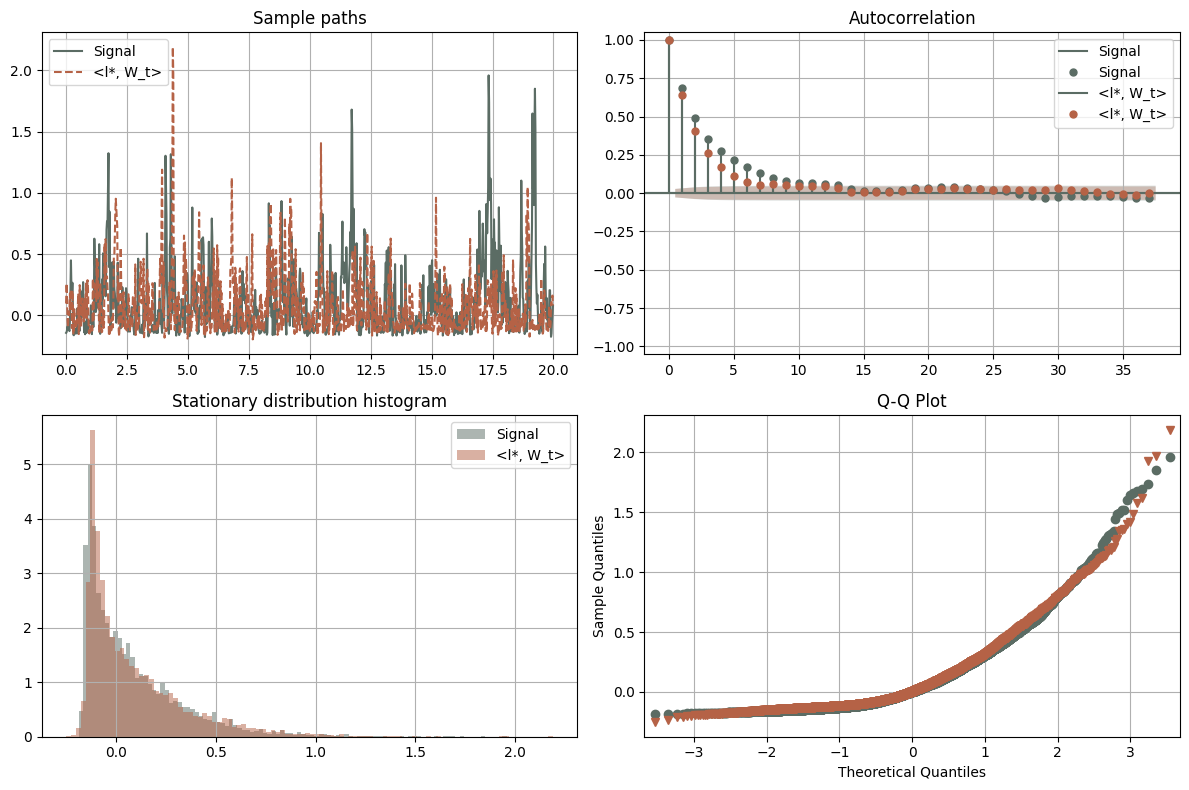

In [466]:
ta.print(model.l)
model.analysis(signal)

In [467]:
model.loss_weights = (1, 0.005)
model.optimizer = "Powell"

In [468]:
model.loss_weights

(1, 0.005)

In [469]:
%%time
model.fit(signal)

Esig: 0.012969270087599637, Stationary moments: 0.0006982959072284215
New iteration: 
 x = [ 0.08598148  0.00128797  0.00699741  0.0094049  -0.01963377 -0.01305614
  0.00128995 -0.00316506], 
 val=0.01366756599482806. 

Esig: 0.012964678438791332, Stationary moments: 0.0006974552517530367
New iteration: 
 x = [ 1.70401545e+00  1.28776702e-03  6.99625656e-03  9.40453261e-03
 -1.97580230e-02 -1.30899781e-02  1.30082767e-03 -3.16767103e-03], 
 val=0.013662133690544368. 

Esig: 0.004818102369805885, Stationary moments: 0.001441035912261021
New iteration: 
 x = [ 2.00701871e+03  1.04053637e-03  5.56697269e-03  8.95136776e-03
 -1.73568745e-01 -5.49736918e-02  1.47760956e-02 -6.40588630e-03], 
 val=0.006259138282066906. 

Esig: 0.004383315756371252, Stationary moments: 0.0003220610411406365
New iteration: 
 x = [ 2.00850646e+03  1.03862710e-03  5.56711571e-03  8.95131896e-03
 -1.73558682e-01 -5.49730754e-02  1.28219945e-02 -6.61636957e-03], 
 val=0.004705376797511888. 

Esig: 0.00420942728217

-0.028594097896711232*∅ + 1.0727295854218424*2 + 5.985058864694888*12 + 9.231357742403823*22 + -168.91227936392502*112 + -56.70168357651039*122 + 12.956016886430195*212 + -6.836876083264059*222


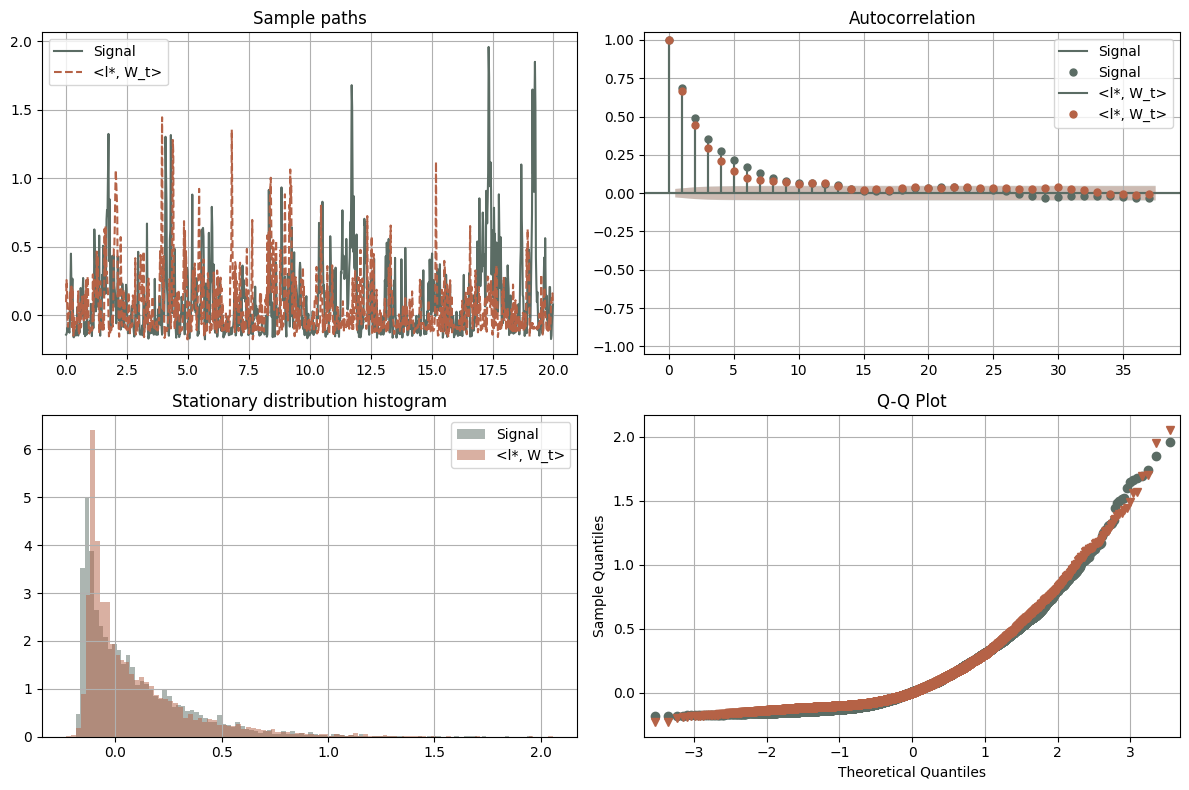

In [470]:
ta.print(model.l)
model.analysis(signal)

In [471]:
model.loss_weights = (1, 0.01)
model.optimizer = "Powell"

In [472]:
model.loss_weights

(1, 0.01)

In [473]:
%%time
model.fit(signal)

Esig: 0.012974547994681486, Stationary moments: 0.0013885800686475214
New iteration: 
 x = [ 0.00783313  0.00128956  0.00696941  0.009405   -0.01957965 -0.01304048
  0.00128434 -0.00316414], 
 val=0.014363128063329008. 

Esig: 0.012971777208069407, Stationary moments: 0.0013875384306713651
New iteration: 
 x = [-3.75045666e+00  1.28943940e-03  6.96875733e-03  9.40479970e-03
 -1.96504416e-02 -1.30601066e-02  1.29149972e-03 -3.16585151e-03], 
 val=0.014359315638740773. 

Esig: 0.011839121348346509, Stationary moments: 0.0009972113421744303
New iteration: 
 x = [-1.27863785e+03  1.24787315e-03  6.74751578e-03  9.33533367e-03
 -4.36959327e-02 -1.97276066e-02  3.73054578e-03 -3.78655247e-03], 
 val=0.01283633269052094. 

Esig: 0.011584077982817834, Stationary moments: 0.0009698595072238582
New iteration: 
 x = [-1.27865936e+03  1.24840293e-03  6.74746240e-03  9.33532714e-03
 -4.05367632e-02 -1.97275285e-02  3.73891790e-03 -3.79038830e-03], 
 val=0.012553937490041692. 

Esig: 0.0114004290515

-0.024503116343432593*∅ + 0.9587627467475813*2 + 5.4774008027705*12 + 7.136194203422628*22 + -28.557743914766863*112 + -15.08332858969091*122 + 2.956106530824677*212 + -2.9954028204089305*222


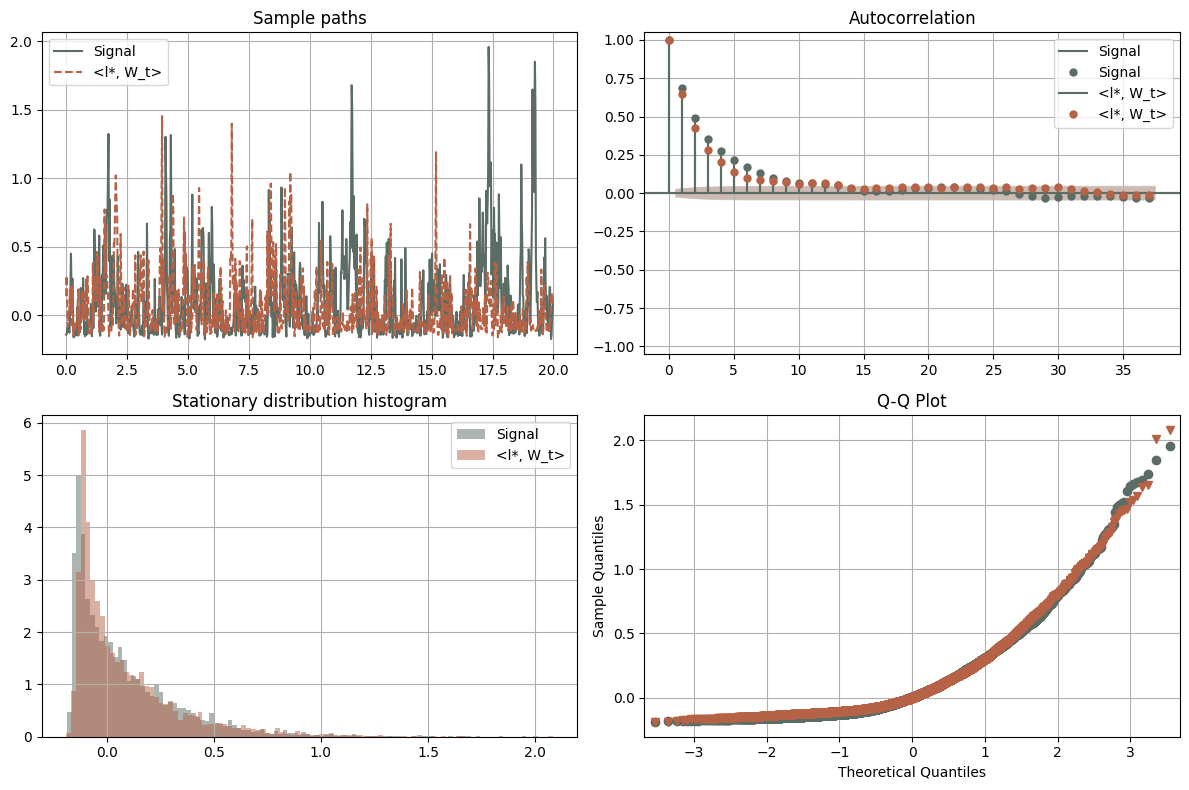

In [474]:
ta.print(model.l)
model.analysis(signal)

In [475]:
model.loss_weights = (1, 0.1)
model.optimizer = "Powell"

In [476]:
model.loss_weights

(1, 0.1)

In [477]:
%%time
model.fit(signal)

Esig: 0.012980935409160538, Stationary moments: 0.013868143718311616
New iteration: 
 x = [ 0.06644639  0.00129053  0.00695427  0.00940511 -0.01953094 -0.0130266
  0.00127968 -0.00316331], 
 val=0.026849079127472156. 

Esig: 0.01297996297000135, Stationary moments: 0.013863601565026796
New iteration: 
 x = [ 1.29599379e+00  1.29047681e-03  6.95406406e-03  9.40503878e-03
 -1.95514374e-02 -1.30313099e-02  1.28074303e-03 -3.16420350e-03], 
 val=0.026843564535028147. 

Esig: 0.012578703558434658, Stationary moments: 0.012337445001406447
New iteration: 
 x = [ 3.79203878e+02  1.27321255e-03  6.89256857e-03  9.38344402e-03
 -2.54943503e-02 -1.44858775e-02  1.51351681e-03 -3.44005274e-03], 
 val=0.024916148559841103. 

Esig: 0.012488652392443546, Stationary moments: 0.012118892404548167
New iteration: 
 x = [ 3.86356671e+02  1.27294589e-03  6.89292998e-03  9.38294517e-03
 -2.52373194e-02 -1.46175593e-02  1.53729051e-03 -3.45376563e-03], 
 val=0.02460754479699171. 

Esig: 0.012459887479628904,

-0.025220257230650495*∅ + 0.9487254000877352*2 + 5.138350809385304*12 + 6.992960959660839*22 + -18.51295518837723*112 + -10.892440634396532*122 + 1.1440290923510033*212 + -2.5745039228890603*222


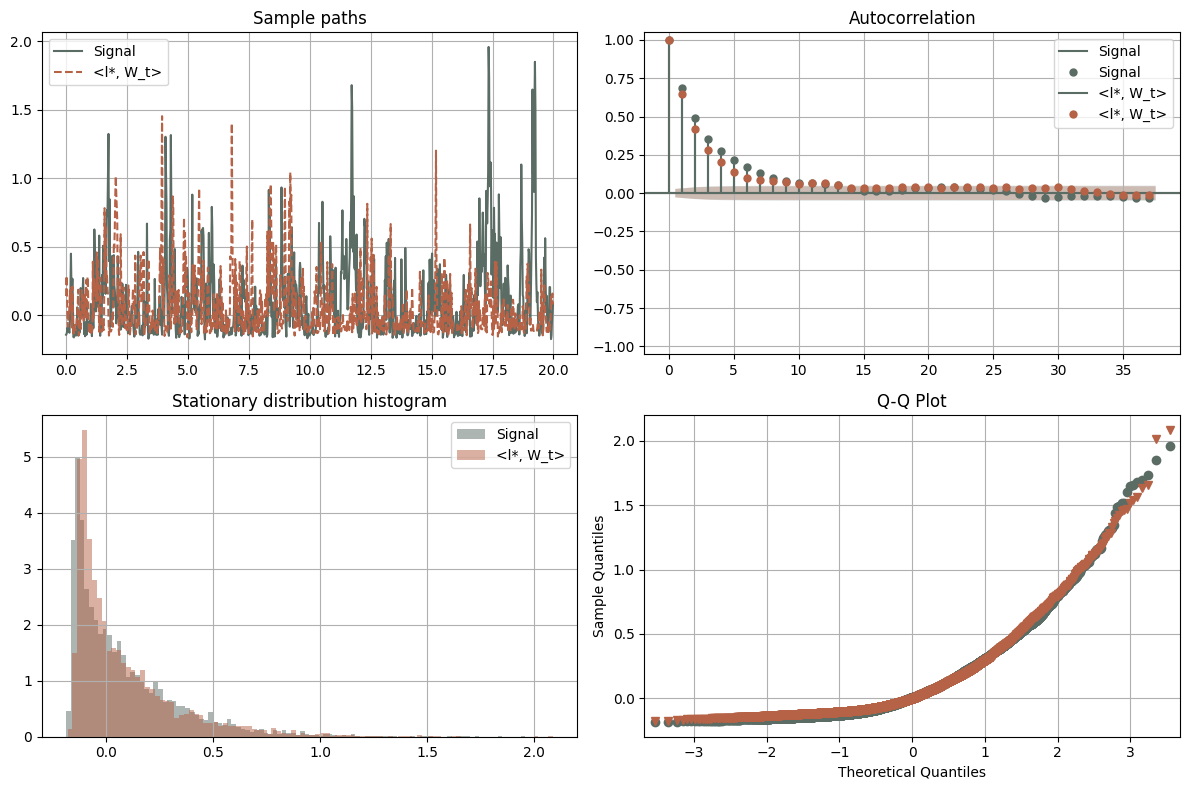

In [478]:
ta.print(model.l)
model.analysis(signal)

In [479]:
model.loss_weights = (1, 0.0006)
model.optimizer = "Powell"

In [480]:
model.loss_weights

(1, 0.0006)

In [481]:
%%time
model.fit(signal)

Esig: 0.012779788758629326, Stationary moments: 0.00012730267786644335
New iteration: 
 x = [ 0.00452324  0.00129794  0.00669174  0.00940259 -0.02040441 -0.01327677
  0.0013666  -0.00317823], 
 val=0.012907091436495769. 

Esig: 0.012748675696311867, Stationary moments: 0.00012645217480350464
New iteration: 
 x = [ 1.37372562e+00  1.29665713e-03  6.68373961e-03  9.40011027e-03
 -2.13027158e-02 -1.35316268e-02  1.45391786e-03 -3.19394542e-03], 
 val=0.012875127871115371. 

Esig: 0.006820570729424804, Stationary moments: 0.0007686906164325837
New iteration: 
 x = [ 2.29268226e+02  1.07141884e-03  5.35496522e-03  8.98815973e-03
 -1.70787214e-01 -5.58131816e-02  1.59405620e-02 -5.83653297e-03], 
 val=0.007589261345857388. 

Esig: 0.003294159303820263, Stationary moments: 0.0003005472258974768
New iteration: 
 x = [ 3.95338853e+02  9.02479375e-04  4.36728985e-03  8.68492922e-03
 -2.79924616e-01 -8.67238185e-02  2.65474355e-02 -7.76888197e-03], 
 val=0.0035947065297177398. 

Esig: 0.003290917

-0.023653202045818167*∅ + 1.2085679780890572*2 + 5.834655550207995*12 + 11.69318284930341*22 + -384.01543421028396*112 + -118.76295761942362*122 + 37.266617117049705*212 + -10.583200480187125*222


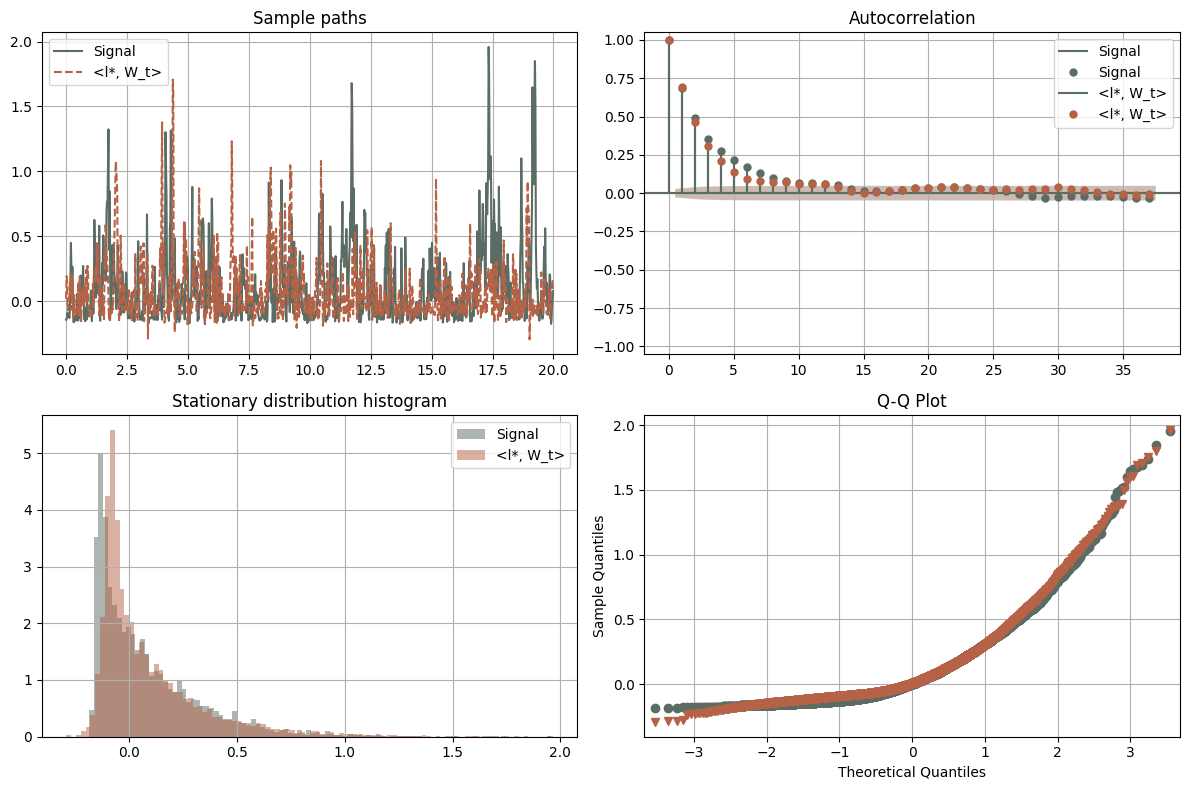

In [482]:
ta.print(model.l)
model.analysis(signal)

In [483]:
model.loss_weights = (1, 0.0009)
model.optimizer = "Powell"

In [484]:
model.loss_weights

(1, 0.0009)

In [485]:
%%time
model.fit(signal)

Esig: 0.01279432171348984, Stationary moments: 0.00015201645234408733
New iteration: 
 x = [ 0.06787101  0.00131068  0.00645086  0.00940296 -0.02011944 -0.01319413
  0.00133779 -0.00317325], 
 val=0.012946338165833926. 

Esig: 0.012773150784953577, Stationary moments: 0.00015123132643679853
New iteration: 
 x = [ 0.07079256  0.0013098   0.00644538  0.00940128 -0.02072873 -0.01336641
  0.00139717 -0.00318407], 
 val=0.012924382111390374. 

Esig: 0.007606392425673376, Stationary moments: 0.00038948717694838427
New iteration: 
 x = [ 1.32603558e+00  1.11155332e-03  5.27253837e-03  9.03932144e-03
 -1.51526583e-01 -5.01768324e-02  1.42106772e-02 -5.51944679e-03], 
 val=0.00799587960262176. 

Esig: 0.003293757253791526, Stationary moments: 0.0004603768490988999
New iteration: 
 x = [ 2.78774975e+00  9.11447592e-04  4.08804459e-03  8.67411859e-03
 -2.83524298e-01 -8.73329218e-02  2.71728474e-02 -7.87432537e-03], 
 val=0.003754134102890426. 

Esig: 0.003293866113058763, Stationary moments: 0.0

-0.01421913233544743*∅ + 1.0847075125958254*2 + 8.500246818797496*12 + 10.832927217901595*22 + -368.9900040883387*112 + -112.14319995789401*122 + 77.07384582443706*212 + -13.034722503420515*222


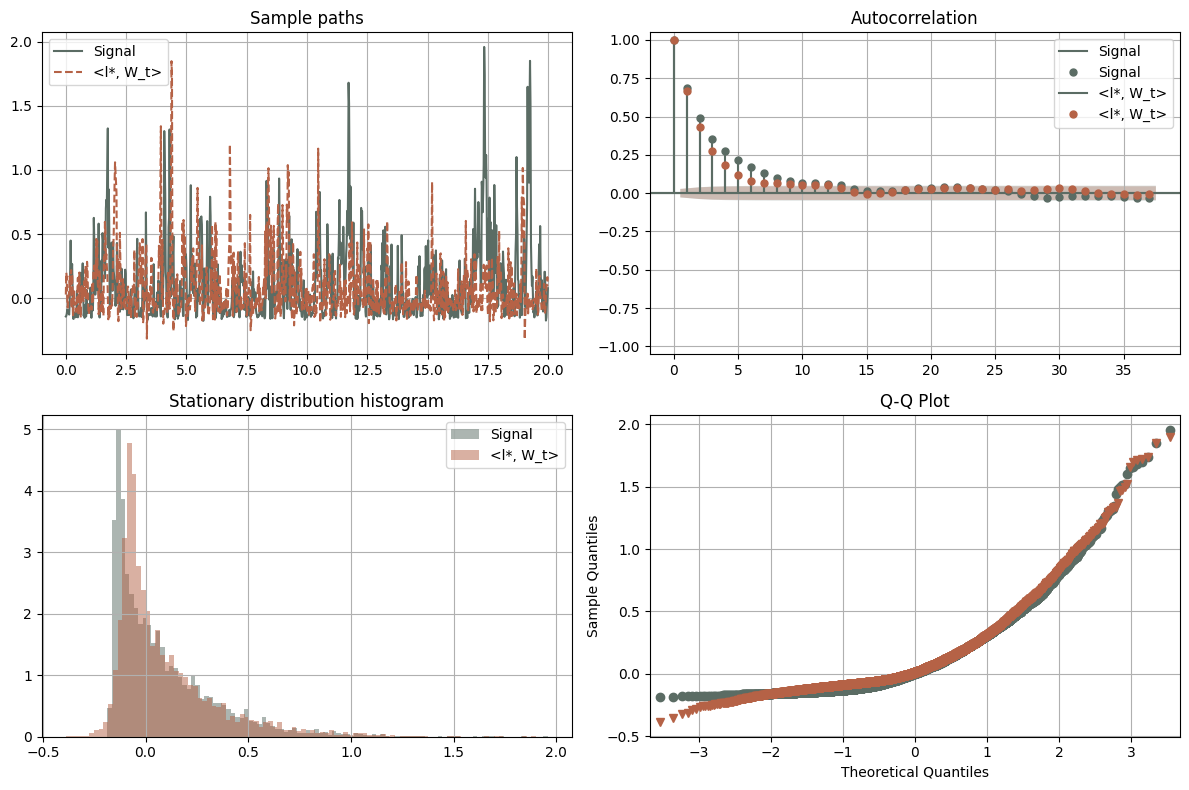

In [486]:
ta.print(model.l)
model.analysis(signal)

In [487]:
model.loss_weights = (1, 0.0007)
model.optimizer = "Powell"

In [488]:
model.loss_weights

(1, 0.0007)

In [489]:
%%time
model.fit(signal)

Esig: 0.012947715042435198, Stationary moments: 0.00013839601939462124
New iteration: 
 x = [ 0.01054846  0.00125625  0.00759793  0.0094034  -0.02027411 -0.01324106
  0.00135248 -0.00317631], 
 val=0.01308611106182982. 

Esig: 0.012920001794411638, Stationary moments: 0.0001379727763381028
New iteration: 
 x = [ 3.31956546e+00  1.25513581e-03  7.59068460e-03  9.40124162e-03
 -2.10441684e-02 -1.34614506e-02  1.42627708e-03 -3.18989644e-03], 
 val=0.01305797457074974. 

Esig: 0.006115283675915836, Stationary moments: 8.375344235203914e-05
New iteration: 
 x = [ 6.39861762e+02  1.02666915e-03  6.20730396e-03  8.98637664e-03
 -1.68794672e-01 -5.57900786e-02  1.56687068e-02 -5.81104772e-03], 
 val=0.006199037118267876. 

Esig: 0.0061041484516629356, Stationary moments: 8.359744710796658e-05
New iteration: 
 x = [ 6.40861762e+02  1.02668382e-03  6.20732182e-03  8.98637664e-03
 -1.68792118e-01 -5.57900786e-02  1.57376489e-02 -5.81857901e-03], 
 val=0.006187745898770902. 

Esig: 0.006100731594

-0.0263240305379807*∅ + 1.0710411288876072*2 + 6.440923738247168*12 + 9.619901626506435*22 + -210.85366802489497*112 + -68.50851175250625*122 + 19.700353373167736*212 + -6.920094815204439*222


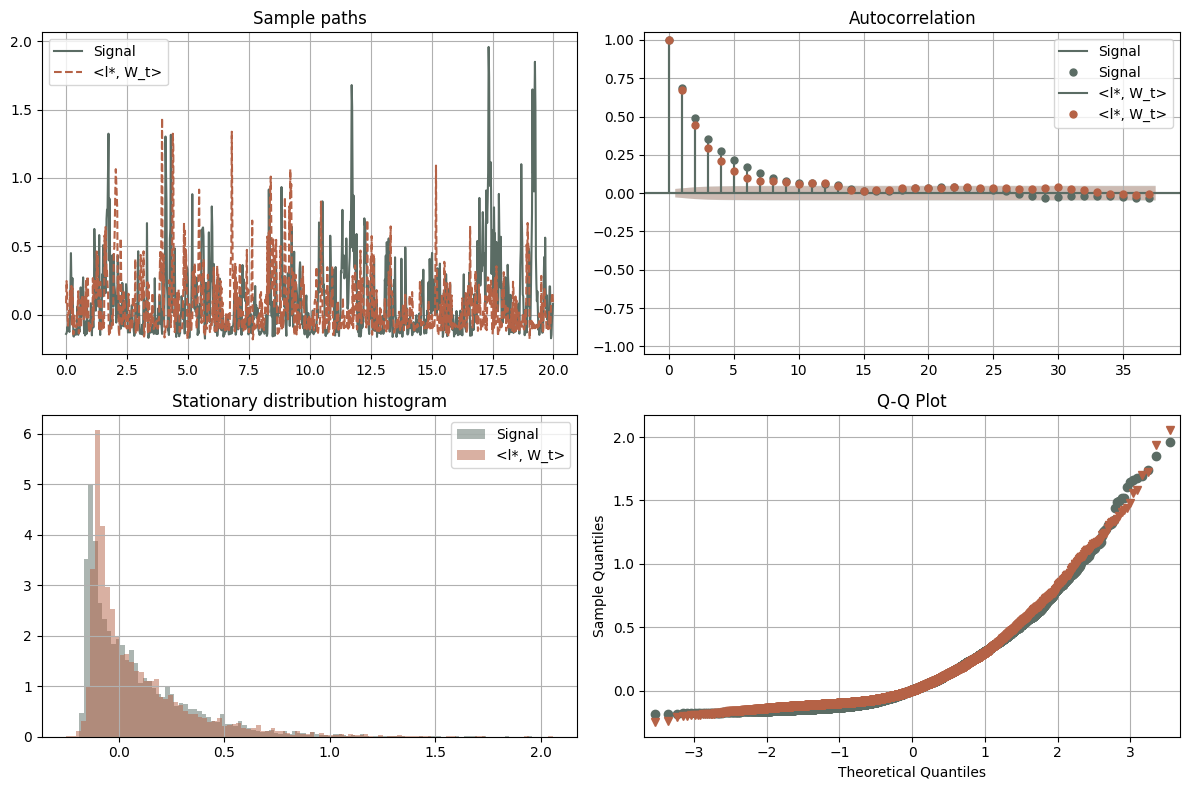

In [490]:
ta.print(model.l)
model.analysis(signal)

In [491]:
model.loss_weights = (1, 0.0008)
model.optimizer = "Powell"

In [492]:
model.loss_weights

(1, 0.0008)

In [493]:
%%time
model.fit(signal)

Esig: 0.012994797981776312, Stationary moments: 0.00014843466587760506
New iteration: 
 x = [-0.00063963  0.00124823  0.00777998  0.00940377 -0.02018328 -0.01321474
  0.00134298 -0.00317473], 
 val=0.013143232647653918. 

Esig: 0.012970660584856816, Stationary moments: 0.0001478431213587347
New iteration: 
 x = [ 1.85461020e+00  1.24723708e-03  7.77371084e-03  9.40195596e-03
 -2.08464761e-02 -1.34075701e-02  1.40755422e-03 -3.18689504e-03], 
 val=0.013118503706215551. 

Esig: 0.007927498928217381, Stationary moments: 5.660863432139931e-05
New iteration: 
 x = [ 3.23049565e+02  1.06234894e-03  6.71467295e-03  9.09261905e-03
 -1.32779218e-01 -4.65446436e-02  1.21616992e-02 -5.27675875e-03], 
 val=0.00798410756253878. 

Esig: 0.003318410779001506, Stationary moments: 0.0003044096297182264
New iteration: 
 x = [ 6.61608948e+02  8.68277454e-04  5.60999173e-03  8.76888307e-03
 -2.49709815e-01 -8.12105753e-02  2.34028060e-02 -7.46652632e-03], 
 val=0.0036228204087197322. 

Esig: 0.00331908566

-0.02608853852454311*∅ + 1.1042484349160062*2 + 7.151338863154309*12 + 11.091824729849543*22 + -312.4119818940854*112 + -101.94469586180917*122 + 29.373686654267562*212 + -9.411327405220804*222


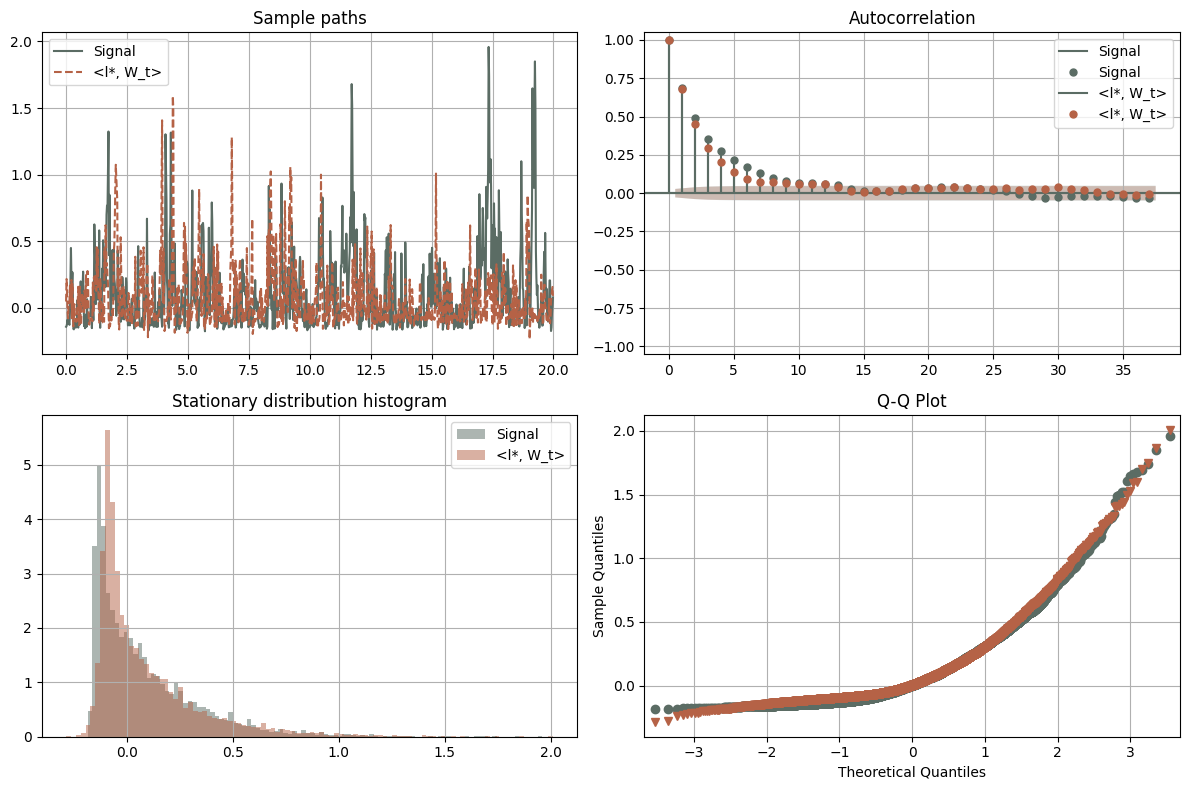

In [494]:
ta.print(model.l)
model.analysis(signal)

#### Strip the BM

In [326]:
%%time
W_strip = strip_bm_path(signal=signal, t_grid=t_grid_pos, ts=ell, trunc=3, lam=lam)

  0%|                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
100%|█████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 161.24it/s]

CPU times: total: 11.9 s
Wall time: 31 s


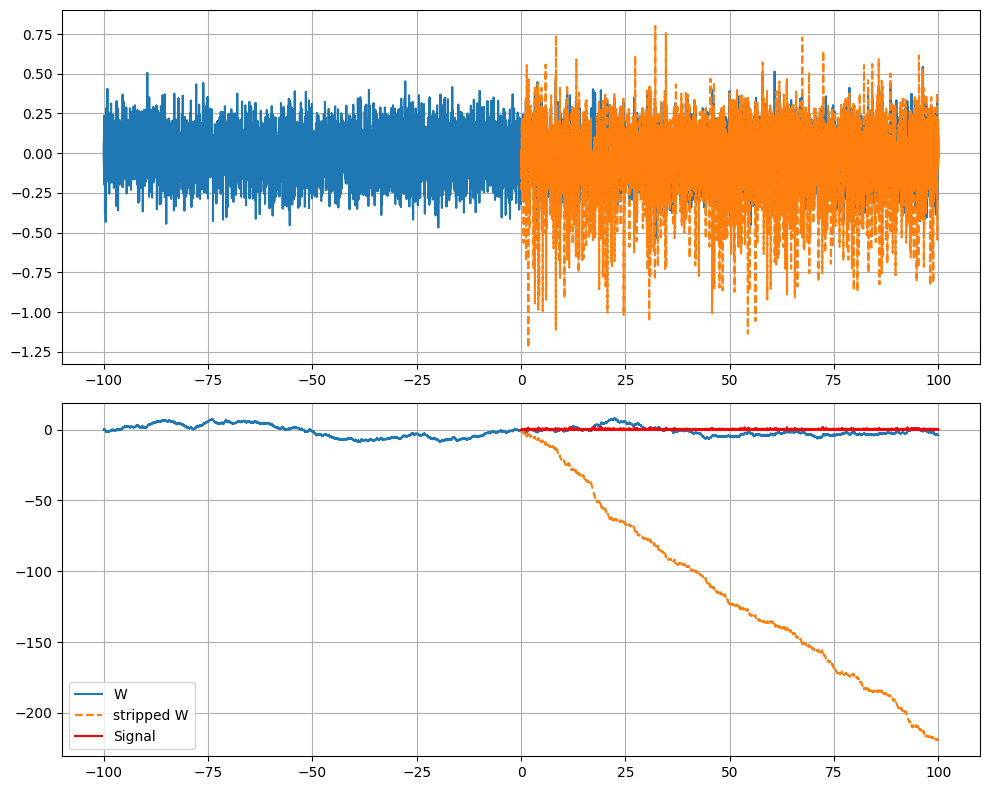

In [327]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(t_grid[1:], np.diff(W))
ax[0].plot(t_grid_pos[1:], np.diff(W_strip), "--")

ax[1].plot(t_grid, W, label="W")
ax[1].plot(t_grid_pos, W_strip - W_strip[0] + W[np.where(t_grid >= 0)[0][0]], "--", label="stripped W")

ax[1].plot(t_grid_pos, signal, 'r', label="Signal")

plt.legend()

# Standard Signatures

In [7]:
T = 4
t_grid = np.linspace(-T, T, 200 + 1)
rng = np.random.default_rng(seed=50)

lam = 10
size = 10

In [8]:
%%time
t_grid_pos = t_grid[t_grid >= 0]

diffusion = Diffusion(t_grid=t_grid_pos, size=size, rng=rng)

path_pos = np.empty((len(t_grid_pos), 2, size))
path_pos[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_pos[:, 1, :] = diffusion.brownian_motion()[:, 0, :].T

Sig = ta.path_to_sequence(path=path_pos, trunc=N)

CPU times: total: 0 ns
Wall time: 31.3 ms


In [9]:
ell = _22
ell_Sig = (ell @ Sig)

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


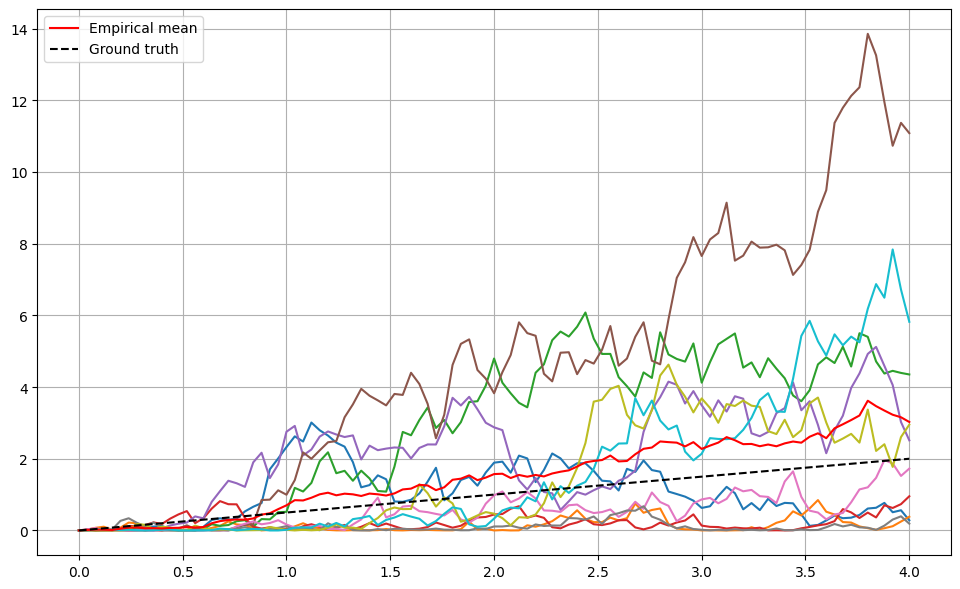

In [10]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i])

plt.plot(t_grid_pos, ell_Sig.mean(axis=1), "r", label="Empirical mean")
plt.plot(t_grid_pos, t_grid_pos / 2, "k--", label="Ground truth")
plt.legend()

#### Calculating the signature of signal

In [11]:
%%time
signal = ell_Sig.real

path_signal = np.empty((len(t_grid_pos), 2, size))
path_signal[:, 0, :] = np.tile(t_grid_pos[:, None], size)
path_signal[:, 1, :] = signal

SignalSig = ta.path_to_sequence(path=path_signal, trunc=N)

CPU times: total: 31.2 ms
Wall time: 28.7 ms


In [59]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments, words

(15,
 ['∅',
  '1',
  '2',
  '11',
  '12',
  '21',
  '22',
  '111',
  '112',
  '121',
  '122',
  '211',
  '212',
  '221',
  '222'])

In [49]:
def signal_signature_coefs_as_bm_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1")
            elif word.endswith("2"):
                signal_sig_coefs_exact[word] = ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("1")).tensor_prod_word("1") + \
                                               ta.shuop.shuffle_prod(signal_sig_coefs_exact[word[:-1]], ts.proj("2")).tensor_prod_word("2")
    return signal_sig_coefs_exact

In [51]:
%%time
signal_sig_coefs_exact = signal_signature_coefs_as_bm_signature_coefs(ell, trunc_moments)

CPU times: total: 15.6 ms
Wall time: 15.6 ms


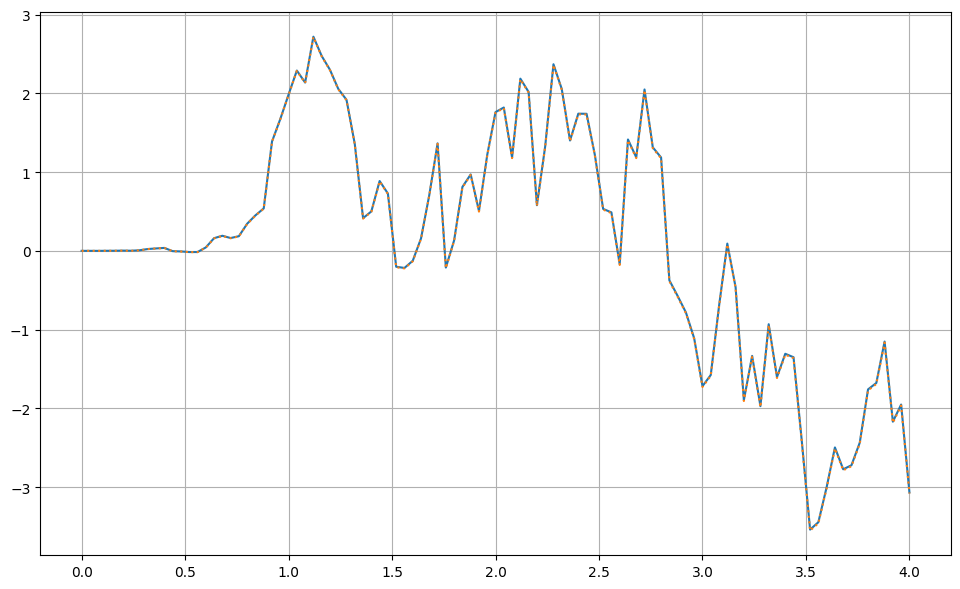

In [52]:
plt.plot(t_grid_pos, (signal_sig_coefs_exact["12"] @ Sig)[:, 0])
plt.plot(t_grid_pos, (e12 @ SignalSig)[:, 0], ":")

In [53]:
%%time
eSig = expected_signature(t=t_grid_pos, trunc=N)

CPU times: total: 344 ms
Wall time: 393 ms


In [54]:
%%time

expected_signal_sig_estimator = dict()
expected_signal_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_sig_estimator[word] = SignalSig.array[idx].mean(axis=1)
    expected_signal_sig_exact[word] = (signal_sig_coefs_exact[word] @ eSig).squeeze()

CPU times: total: 0 ns
Wall time: 31.3 ms


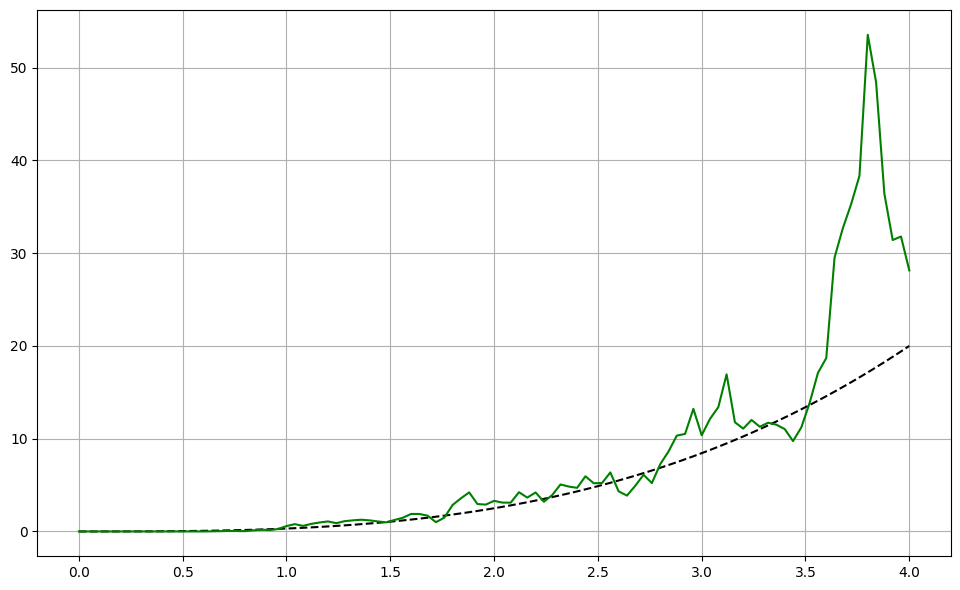

In [55]:
w = "222"
plt.plot(t_grid_pos, expected_signal_sig_exact[w], "k--")
plt.plot(t_grid_pos, expected_signal_sig_estimator[w], "g")

##### Loss functional for a given $l$

In [60]:
ell_trunc = 3

def loss(x):    
    l = ta.from_array(N, x)
    signal_sig_coefs = signal_signature_coefs_as_bm_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_sig_coefs[word] @ eSig).squeeze() - expected_signal_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [61]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [64]:
%%time
loss(x0)

CPU times: total: 0 ns
Wall time: 28.2 ms


30.426108510889854

In [65]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [0.00000000e+00 5.73625955e-02 0.00000000e+00 9.77580749e-02
 0.00000000e+00 0.00000000e+00 2.86812974e-02 1.13985344e-01
 1.88467028e-09 0.00000000e+00 4.88790387e-02 0.00000000e+00
 0.00000000e+00 4.88790368e-02 6.28223427e-10], 
 val=18.851680699502506. 

New iteration: 
 x = [0.00000000e+00 1.75144739e-01 0.00000000e+00 1.40071620e-01
 6.58770217e-09 3.29385108e-09 1.31422433e-01 2.97569780e-02
 1.27988873e-08 6.58770217e-09 1.27740843e-01 6.58770217e-09
 4.19982383e-02 1.20948642e-01 9.75604757e-09], 
 val=14.462331323872071. 

New iteration: 
 x = [0.00000000e+00 1.84719471e-01 9.44162900e-10 1.42602047e-01
 8.65965022e-09 4.84482306e-09 1.46346412e-01 2.08947714e-02
 1.57684666e-08 8.65965022e-09 1.41321835e-01 8.40215125e-09
 5.22701390e-02 1.32698284e-01 1.27014187e-08], 
 val=14.020911538998943. 

New iteration: 
 x = [ 0.00000000e+00  1.57427833e-01  3.19990418e-07  4.26519080e-01
  3.02956115e-07  3.88377096e-07  5.68094208e-01 -2.12507432e-01
  2.86189

In [66]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

-0.0001749707261527009*1 + 0.012687623518143941*2 + -0.019768666252624086*11 + -0.05706982538633185*12 + 0.02636239419425755*21 + 1.0003481480379528*22 + -2.998792807214509e-07*111 + 0.015530431297588706*112 + 0.006324396457695697*121 + 0.03912291988481668*122 + -0.011320818125559243*211 + -0.04248578982503874*212 + 0.0004158927016751447*221 + -0.01867558180634447*222


In [67]:
l_Sig = l_opt @ Sig

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


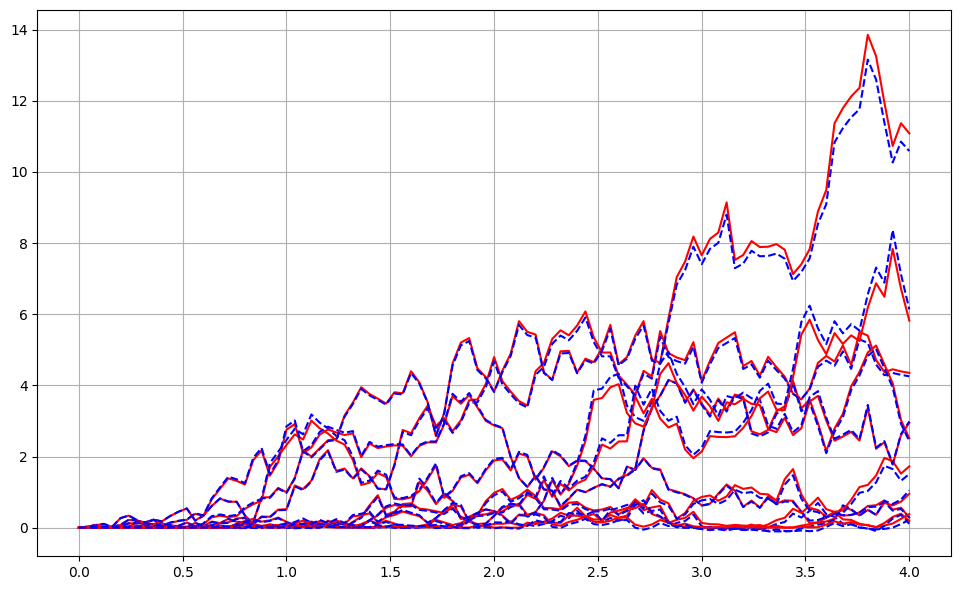

In [68]:
for i in range(10):
    plt.plot(t_grid_pos, ell_Sig[:, i], "r")
    plt.plot(t_grid_pos, l_Sig[:, i], "b--")

## Stationary Signature of signal (does not work properly)

In [150]:
T = 50
t_grid = np.linspace(-T, T, 10000 + 1)
t_grid_pos = t_grid[t_grid >= 0]
rng = np.random.default_rng(seed=50)

lam = 3
size = 2

In [151]:
%%time
diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]
path = np.vstack([t_grid, W]).T
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_grid, lam=lam)

W2 = diffusion.brownian_motion()[1, 0, :]
path2 = np.vstack([t_grid, W2]).T
SigS_test = stationary_signature_from_path(path=path2, trunc=trunc_moments, t_grid=t_grid, lam=lam)

CPU times: total: 29 s
Wall time: 31.2 s


In [298]:
ell = e2 + e22 * 2
ell_SigS = (ell @ SigS).squeeze().real
ell_SigS_test = (ell @ SigS_test).squeeze().real

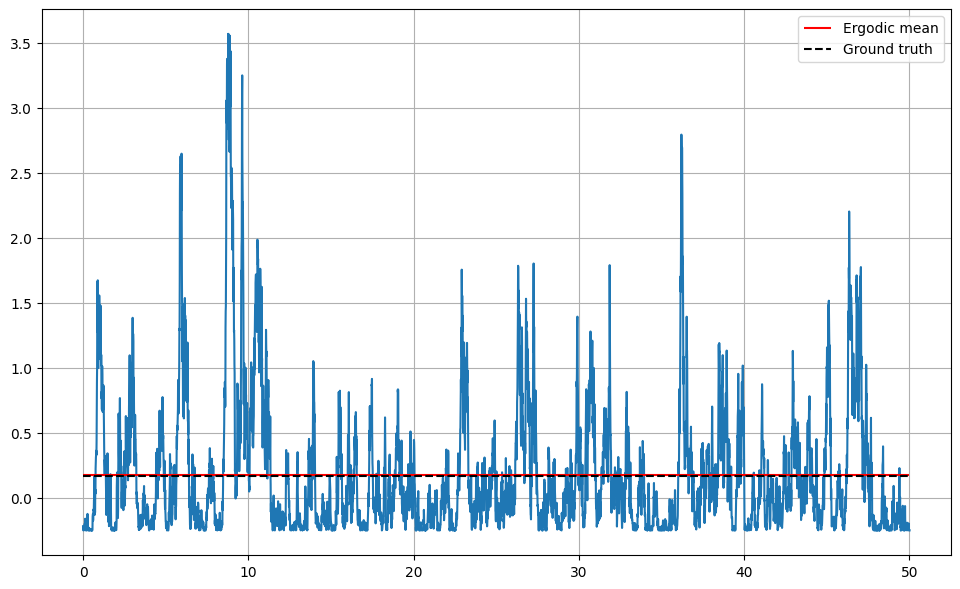

In [301]:
plt.plot(t_grid_pos, ell_SigS)

plt.hlines(ell_SigS.mean(), t_grid_pos[0], t_grid_pos[-1], "r", label="Ergodic mean")
plt.hlines(1 / 2 / lam, t_grid_pos[0], t_grid_pos[-1], "k", linestyles="--", label="Ground truth")

plt.legend()

#### Calculating the signature of signal

In [14]:
%%time
signal = ell_SigS.real

path_signal = np.empty((len(t_grid_pos), 2))
path_signal[:, 0] = t_grid_pos
path_signal[:, 1] = signal

SignalSigS = stationary_signature_from_path(path=path_signal, trunc=N, t_grid=t_grid_pos - 15, lam=lam)

t_grid_s = t_grid_pos[t_grid_pos >= 15]

CPU times: total: 11.4 s
Wall time: 12 s


In [91]:
trunc_moments = 3
n_moments = ta.alphabet.number_of_elements(trunc_moments)
words = [ta.alphabet.index_to_word(idx) for idx in range(n_moments)]

n_moments

15

In [21]:
def resolvent(mu, lam, ts):
    tmp = ts * 1
    res = ts * 1
    for i in range(N):
        tmp.update(G(tmp) * lam - tmp * mu)
        tmp.update(tmp.tensor_prod_word("1"))
        res.update(res + tmp)

    return res

In [22]:
def signal_stat_signature_coefs_as_bm_stat_signature_coefs(ts, trunc_moments):
    signal_sig_coefs_exact = dict()
    n_moments = ta.alphabet.number_of_elements(trunc_moments)

    for idx in range(n_moments):
        word = ta.alphabet.index_to_word(idx)
        if not idx:
            signal_sig_coefs_exact[""] = TensorSequence.unit(ta.alphabet, N)
        else:
            if word.endswith("1"):
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=signal_sig_coefs_exact[word[:-1]].tensor_prod_word("1"))
            elif word.endswith("2"):
                coef_prev = signal_sig_coefs_exact[word[:-1]]
                c = (ta.shuop.shuffle_prod(coef_prev, ts.proj("1") - G(ts) * lam) - ta.shuop.shuffle_prod(coef_prev.proj("2") / 2, ts.proj("2"))).tensor_prod_word("1") + \
                    ta.shuop.shuffle_prod(coef_prev, ts.proj("2")).tensor_prod_word("2")
                signal_sig_coefs_exact[word] = resolvent(mu=len(word) * lam, lam=lam, ts=c)
    return signal_sig_coefs_exact

In [23]:
%%time
signal_stat_sig_coefs_exact = signal_stat_signature_coefs_as_bm_stat_signature_coefs(ell, trunc_moments)

CPU times: total: 5.41 s
Wall time: 6.2 s


In [24]:
ta.print(signal_stat_sig_coefs_exact["222"])

-1.0*22122 + -3.0*22212 + -6.0*22221 + -3.0*221122 + -3.0*221212 + 3.0*221221 + -9.0*222112 + 9.0*222121 + 18.0*222211 + 15.0*222222 + -18.0*2211122 + -18.0*2211212 + 9.0*2211221 + -18.0*2212112 + 9.0*2212121 + 63.0*2212211 + -9.0*2212222 + -54.0*2221112 + 27.0*2221121 + 189.0*2221211 + -27.0*2221222 + 378.0*2222111 + -54.0*2222122 + -90.0*2222212 + -135.0*2222221 + -162.0*22111122 + -162.0*22111212 + 54.0*22111221 + -162.0*22112112 + 54.0*22112121 + 378.0*22112211 + -54.0*22112222 + -162.0*22121112 + 54.0*22121121 + 378.0*22121211 + -54.0*22121222 + 1026.0*22122111 + -45.0*22122122 + -27.0*22122212 + -486.0*22211112 + 162.0*22211121 + 1134.0*22211211 + -162.0*22211222 + 3078.0*22212111 + -135.0*22212122 + -81.0*22212212 + 6156.0*22221111 + -270.0*22221122 + -162.0*22221212 + -270.0*22222112 + -1944.0*221111122 + -1944.0*221111212 + 486.0*221111221 + -1944.0*221112112 + 486.0*221112121 + 3726.0*221112211 + -486.0*221112222 + -1944.0*221121112 + 486.0*221121121 + 3726.0*221121211 + -486

In [25]:
SigS.array.shape

(1023, 5001, 1)

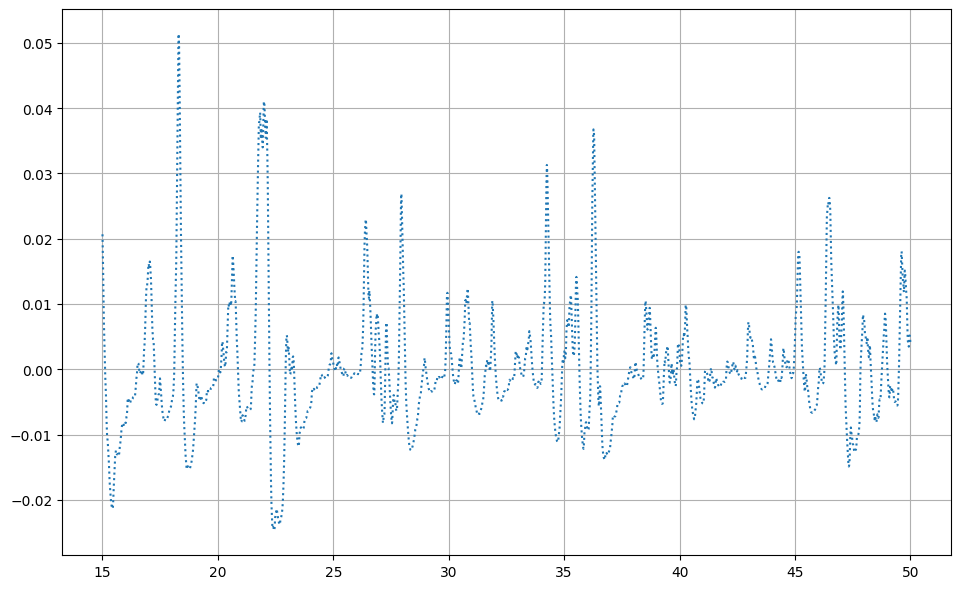

In [30]:
# plt.plot(t_grid_s, (signal_stat_sig_coefs_exact["222"] @ SigS).squeeze()[t_grid_pos >= 15])
plt.plot(t_grid_s, (e21 @ SignalSigS), ":")

In [31]:
%%time
eSigS = expected_stationary_signature(lam=lam, trunc=N)

CPU times: total: 5.41 s
Wall time: 8.23 s


In [281]:
%%time

expected_signal_stat_sig_estimator = dict()
expected_signal_stat_sig_exact = dict()

for idx in range(n_moments):
    word = ta.alphabet.index_to_word(idx)
    if word == "∅":
        word = ""
    expected_signal_stat_sig_estimator[word] = SignalSigS.array[idx].mean()
    expected_signal_stat_sig_exact[word] = (signal_stat_sig_coefs_exact[word] @ eSigS).squeeze()

CPU times: total: 0 ns
Wall time: 0 ns


In [283]:
w = "2"
expected_signal_stat_sig_estimator[w], expected_signal_stat_sig_exact[w]

((1.4819416621710028e-05+0j), array(0.00833333+0.j))

##### Loss functional for a given $l$

In [289]:
ell_trunc = 3

def loss_stat(x):    
    l = ta.from_array(N, x)
    signal_stat_sig_coefs = signal_stat_signature_coefs_as_bm_stat_signature_coefs(l, trunc_moments)
    
    loss = 0
    for word in words:
        if "2" in word:
            # Moments are supposed to be known exactly
            loss_word = np.sqrt(np.mean(np.abs((signal_stat_sig_coefs[word] @ eSigS).squeeze() - expected_signal_stat_sig_exact[word])**2))
            loss += loss_word
    
    return loss

In [290]:
x0 = np.zeros(ta.alphabet.number_of_elements(ell_trunc))

In [291]:
%%time
loss_stat(x0)

CPU times: total: 46.9 ms
Wall time: 94.2 ms


0.010321093750000001

In [293]:
%%time

from scipy.optimize import minimize

def callback(x, f=None, context=None, accept=None, convergence=None):
    val = loss_stat(x)
    print(f"New iteration: \n x = {x}, \n val={val}. \n")

res = minimize(loss_stat, x0, callback=callback, method="BFGS")
print(res)

New iteration: 
 x = [ 0.00000000e+00  3.02261860e-01 -3.10481573e-09  3.02261868e-02
  0.00000000e+00  0.00000000e+00  1.25294210e-01  1.51130787e-03
  0.00000000e+00  0.00000000e+00  1.25294218e-02  0.00000000e+00
  0.00000000e+00  6.26471089e-03  0.00000000e+00], 
 val=0.0022176860482609755. 

New iteration: 
 x = [ 0.00000000e+00  3.51610595e-01 -3.54563448e-09  3.51757401e-02
  0.00000000e+00  0.00000000e+00  1.45847824e-01  1.75944838e-03
  0.00000000e+00  0.00000000e+00  1.45880485e-02  0.00000000e+00
  1.26712280e-06  7.29250426e-03  0.00000000e+00], 
 val=0.0011075077325957319. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563451e-09  3.51757406e-02
 -5.11220152e-18  0.00000000e+00  1.45847825e-01  1.75944840e-03
  0.00000000e+00  0.00000000e+00  1.45880487e-02  0.00000000e+00
  1.26712333e-06  7.29250436e-03 -1.70406717e-18], 
 val=0.0011075076513443784. 

New iteration: 
 x = [ 0.00000000e+00  3.51610598e-01 -3.54563442e-09  3.51757427e-02
 -1.42969984e-17  0.

In [295]:
l_opt = ta.from_array(moments_trunc, res.x)
ta.print(l_opt)

0.3516105983634915*1 + 0.03517576155534584*11 + 0.14584783466533074*22 + 0.0017595189129007553*111 + 0.014588074290246009*122 + 1.28419076285507e-06*212 + 0.007292498171109511*221


In [298]:
l_SigS = l_opt @ SigS

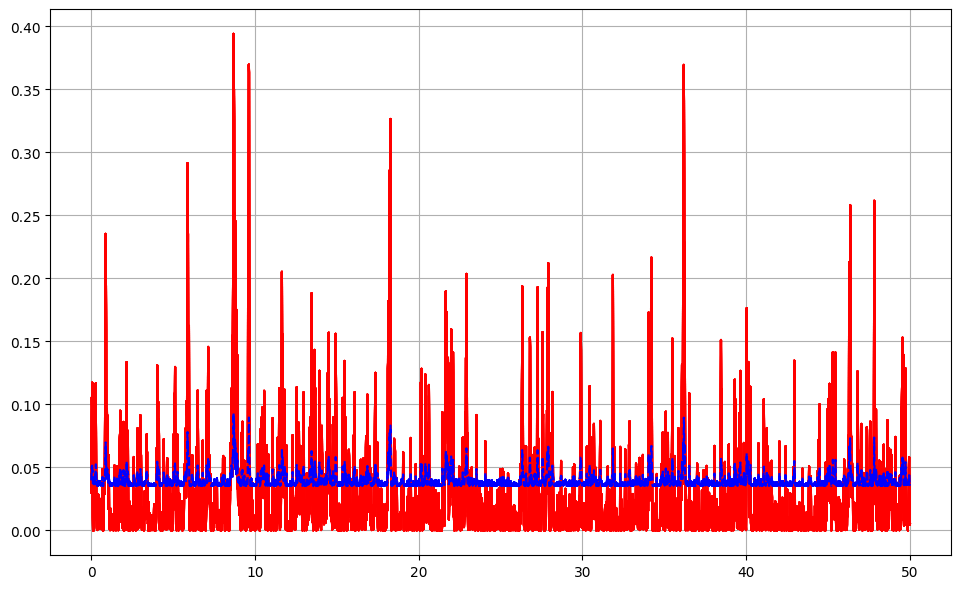

In [299]:
for i in range(10):
    plt.plot(t_grid_pos, ell_SigS, "r")
    plt.plot(t_grid_pos, l_SigS, "b--")